# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=75,
        fold=5,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_18-36-07/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191905 [00:00<?, ?it/s]

  0%|          | 0/21691 [00:00<?, ?it/s]

  0%|          | 0/53056 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191905 [00:00<?, ?it/s]

  0%|          | 0/53056 [00:00<?, ?it/s]

  0%|          | 0/21691 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4754 | MulticlassF1Score=0.1099
Batch-30 : CrossEntropyLoss=2.4640 | MulticlassF1Score=0.1860
Batch-45 : CrossEntropyLoss=2.4765 | MulticlassF1Score=0.2120
Batch-60 : CrossEntropyLoss=2.4489 | MulticlassF1Score=0.2337
Batch-75 : CrossEntropyLoss=2.4757 | MulticlassF1Score=0.2453
Batch-90 : CrossEntropyLoss=2.4554 | MulticlassF1Score=0.2549
Batch-105: CrossEntropyLoss=2.4594 | MulticlassF1Score=0.2682
Batch-120: CrossEntropyLoss=2.4440 | MulticlassF1Score=0.2853
Batch-135: CrossEntropyLoss=2.4276 | MulticlassF1Score=0.2997
Batch-150: CrossEntropyLoss=2.4417 | MulticlassF1Score=0.3108
Batch-165: CrossEntropyLoss=2.4152 | MulticlassF1Score=0.3195
Batch-180: CrossEntropyLoss=2.4106 | MulticlassF1Score=0.3273
Batch-195: CrossEntropyLoss=2.4331 | MulticlassF1Score=0.3374
Batch-210: CrossEntropyLoss=2.4293 | MulticlassF1Score=0.3477
Batch-225: CrossEntropyLoss=2.4083 | MulticlassF1Score=0.3567
Batch-226: CrossEntropyLoss=2.4134 | MulticlassF1Score=0.3572

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4130 | MulticlassF1Score=0.4614
Batch-30 : CrossEntropyLoss=2.4016 | MulticlassF1Score=0.4739
Batch-45 : CrossEntropyLoss=2.4368 | MulticlassF1Score=0.4745
Batch-60 : CrossEntropyLoss=2.4034 | MulticlassF1Score=0.4755
Batch-63 : CrossEntropyLoss=2.4171 | MulticlassF1Score=0.4760

Training   : Mean CrossEntropyLoss = 2.4555 | Mean MulticlassF1Score = 0.2623
Validation : Mean CrossEntropyLoss = 2.4097 | Mean MulticlassF1Score = 0.4720

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4211 | MulticlassF1Score=0.4824
Batch-30 : CrossEntropyLoss=2.3997 | MulticlassF1Score=0.4852
Batch-45 : CrossEntropyLoss=2.4202 | MulticlassF1Score=0.4854
Batch-60 : CrossEntropyLoss=2.3979 | MulticlassF1Score=0.4826
Batch-75 : CrossEntropyLoss=2.4040 | MulticlassF1Score=0.4822
Batch-90 : CrossEntropyLoss=2.4118 | MulticlassF1Score=0.4815
Batch-105: CrossEntropyLoss=2.3679 | MulticlassF1Score=0.4943
Batch-120: CrossEntropyLoss=2.3748 | MulticlassF1Score=0.5067
Batch-135: CrossEntropyLoss=2.3693 | MulticlassF1Score=0.5160
Batch-150: CrossEntropyLoss=2.3737 | MulticlassF1Score=0.5233
Batch-165: CrossEntropyLoss=2.3583 | MulticlassF1Score=0.5287
Batch-180: CrossEntropyLoss=2.3655 | MulticlassF1Score=0.5342
Batch-195: CrossEntropyLoss=2.3663 | MulticlassF1Score=0.5388
Batch-210: CrossEntropyLoss=2.3659 | MulticlassF1Score=0.5425
Batch-225: CrossEntropyLoss=2.3457 | MulticlassF1Score=0.5503
Batch-226: CrossEntropyLoss=2.3323 | MulticlassF1Score=0.5507

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3624 | MulticlassF1Score=0.6586
Batch-30 : CrossEntropyLoss=2.3648 | MulticlassF1Score=0.6618
Batch-45 : CrossEntropyLoss=2.3436 | MulticlassF1Score=0.6627
Batch-60 : CrossEntropyLoss=2.3395 | MulticlassF1Score=0.6640
Batch-63 : CrossEntropyLoss=2.3719 | MulticlassF1Score=0.6636

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3874 | Mean MulticlassF1Score = 0.5069
Validation : Mean CrossEntropyLoss = 2.3530 | Mean MulticlassF1Score = 0.6604

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3601 | MulticlassF1Score=0.6701
Batch-30 : CrossEntropyLoss=2.3562 | MulticlassF1Score=0.6736
Batch-45 : CrossEntropyLoss=2.3385 | MulticlassF1Score=0.6735
Batch-60 : CrossEntropyLoss=2.3491 | MulticlassF1Score=0.6728
Batch-75 : CrossEntropyLoss=2.3376 | MulticlassF1Score=0.6727
Batch-90 : CrossEntropyLoss=2.3430 | MulticlassF1Score=0.6722
Batch-105: CrossEntropyLoss=2.3269 | MulticlassF1Score=0.6768
Batch-120: CrossEntropyLoss=2.3332 | MulticlassF1Score=0.6821
Batch-135: CrossEntropyLoss=2.3249 | MulticlassF1Score=0.6873
Batch-150: CrossEntropyLoss=2.3216 | MulticlassF1Score=0.6947
Batch-165: CrossEntropyLoss=2.3157 | MulticlassF1Score=0.7017
Batch-180: CrossEntropyLoss=2.3221 | MulticlassF1Score=0.7067
Batch-195: CrossEntropyLoss=2.3183 | MulticlassF1Score=0.7114
Batch-210: CrossEntropyLoss=2.3106 | MulticlassF1Score=0.7170
Batch-225: CrossEntropyLoss=2.3167 | MulticlassF1Score=0.7218
Batch-226: CrossEntropyLoss=2.3112 | MulticlassF1Score=0.7220

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3171 | MulticlassF1Score=0.7913
Batch-30 : CrossEntropyLoss=2.3215 | MulticlassF1Score=0.7837
Batch-45 : CrossEntropyLoss=2.3173 | MulticlassF1Score=0.7838
Batch-60 : CrossEntropyLoss=2.3139 | MulticlassF1Score=0.7836
Batch-63 : CrossEntropyLoss=2.3301 | MulticlassF1Score=0.7824

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3347 | Mean MulticlassF1Score = 0.6877
Validation : Mean CrossEntropyLoss = 2.3155 | Mean MulticlassF1Score = 0.7856

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3224 | MulticlassF1Score=0.7856
Batch-30 : CrossEntropyLoss=2.3107 | MulticlassF1Score=0.7860
Batch-45 : CrossEntropyLoss=2.3108 | MulticlassF1Score=0.7868
Batch-60 : CrossEntropyLoss=2.3031 | MulticlassF1Score=0.7883
Batch-75 : CrossEntropyLoss=2.3127 | MulticlassF1Score=0.7887
Batch-90 : CrossEntropyLoss=2.3102 | MulticlassF1Score=0.7882
Batch-105: CrossEntropyLoss=2.3146 | MulticlassF1Score=0.7886
Batch-120: CrossEntropyLoss=2.3033 | MulticlassF1Score=0.7885
Batch-135: CrossEntropyLoss=2.3175 | MulticlassF1Score=0.7884
Batch-150: CrossEntropyLoss=2.3109 | MulticlassF1Score=0.7890
Batch-165: CrossEntropyLoss=2.3146 | MulticlassF1Score=0.7887
Batch-180: CrossEntropyLoss=2.3098 | MulticlassF1Score=0.7891
Batch-195: CrossEntropyLoss=2.3183 | MulticlassF1Score=0.7892
Batch-210: CrossEntropyLoss=2.3173 | MulticlassF1Score=0.7894
Batch-225: CrossEntropyLoss=2.3155 | MulticlassF1Score=0.7898
Batch-226: CrossEntropyLoss=2.3053 | MulticlassF1Score=0.7898

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3120 | MulticlassF1Score=0.7804
Batch-30 : CrossEntropyLoss=2.3144 | MulticlassF1Score=0.7809
Batch-45 : CrossEntropyLoss=2.3186 | MulticlassF1Score=0.7828
Batch-60 : CrossEntropyLoss=2.3001 | MulticlassF1Score=0.7859
Batch-63 : CrossEntropyLoss=2.3123 | MulticlassF1Score=0.7863

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3132 | Mean MulticlassF1Score = 0.7883
Validation : Mean CrossEntropyLoss = 2.3137 | Mean MulticlassF1Score = 0.7822

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3115 | MulticlassF1Score=0.7878
Batch-30 : CrossEntropyLoss=2.3064 | MulticlassF1Score=0.7941
Batch-45 : CrossEntropyLoss=2.3126 | MulticlassF1Score=0.7932
Batch-60 : CrossEntropyLoss=2.3155 | MulticlassF1Score=0.7935
Batch-75 : CrossEntropyLoss=2.3128 | MulticlassF1Score=0.7925
Batch-90 : CrossEntropyLoss=2.3134 | MulticlassF1Score=0.7923
Batch-105: CrossEntropyLoss=2.3121 | MulticlassF1Score=0.7934
Batch-120: CrossEntropyLoss=2.3110 | MulticlassF1Score=0.7936
Batch-135: CrossEntropyLoss=2.3138 | MulticlassF1Score=0.7934
Batch-150: CrossEntropyLoss=2.3044 | MulticlassF1Score=0.7952
Batch-165: CrossEntropyLoss=2.2996 | MulticlassF1Score=0.7966
Batch-180: CrossEntropyLoss=2.2984 | MulticlassF1Score=0.7973
Batch-195: CrossEntropyLoss=2.3098 | MulticlassF1Score=0.7982
Batch-210: CrossEntropyLoss=2.3029 | MulticlassF1Score=0.7991
Batch-225: CrossEntropyLoss=2.3087 | MulticlassF1Score=0.8001
Batch-226: CrossEntropyLoss=2.3112 | MulticlassF1Score=0.7999

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3059 | MulticlassF1Score=0.7992
Batch-30 : CrossEntropyLoss=2.3113 | MulticlassF1Score=0.8032
Batch-45 : CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8063
Batch-60 : CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8072
Batch-63 : CrossEntropyLoss=2.3073 | MulticlassF1Score=0.8072

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3098 | Mean MulticlassF1Score = 0.7947
Validation : Mean CrossEntropyLoss = 2.3071 | Mean MulticlassF1Score = 0.8020

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3101 | MulticlassF1Score=0.8213
Batch-30 : CrossEntropyLoss=2.3095 | MulticlassF1Score=0.8191
Batch-45 : CrossEntropyLoss=2.3112 | MulticlassF1Score=0.8160
Batch-60 : CrossEntropyLoss=2.3144 | MulticlassF1Score=0.8153
Batch-75 : CrossEntropyLoss=2.3103 | MulticlassF1Score=0.8145
Batch-90 : CrossEntropyLoss=2.3143 | MulticlassF1Score=0.8146
Batch-105: CrossEntropyLoss=2.3143 | MulticlassF1Score=0.8142
Batch-120: CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8141
Batch-135: CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8143
Batch-150: CrossEntropyLoss=2.3153 | MulticlassF1Score=0.8150
Batch-165: CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8165
Batch-180: CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8172
Batch-195: CrossEntropyLoss=2.3138 | MulticlassF1Score=0.8176
Batch-210: CrossEntropyLoss=2.3081 | MulticlassF1Score=0.8181
Batch-225: CrossEntropyLoss=2.3045 | MulticlassF1Score=0.8190
Batch-226: CrossEntropyLoss=2.3041 | MulticlassF1Score=0.8191

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3031 | MulticlassF1Score=0.8098
Batch-30 : CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8153
Batch-45 : CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8190
Batch-60 : CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8185
Batch-63 : CrossEntropyLoss=2.3002 | MulticlassF1Score=0.8183

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3038 | Mean MulticlassF1Score = 0.8170
Validation : Mean CrossEntropyLoss = 2.3037 | Mean MulticlassF1Score = 0.8157

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8271
Batch-30 : CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8279
Batch-45 : CrossEntropyLoss=2.3103 | MulticlassF1Score=0.8275
Batch-60 : CrossEntropyLoss=2.3029 | MulticlassF1Score=0.8267
Batch-75 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8271
Batch-90 : CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8289
Batch-105: CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8307
Batch-120: CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8326
Batch-135: CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8335
Batch-150: CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8346
Batch-165: CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8358
Batch-180: CrossEntropyLoss=2.3078 | MulticlassF1Score=0.8362
Batch-195: CrossEntropyLoss=2.3031 | MulticlassF1Score=0.8364
Batch-210: CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8367
Batch-225: CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8368
Batch-226: CrossEntropyLoss=2.3057 | MulticlassF1Score=0.8367

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8431
Batch-30 : CrossEntropyLoss=2.3072 | MulticlassF1Score=0.8377
Batch-45 : CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8354
Batch-60 : CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8354
Batch-63 : CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8352

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2985 | Mean MulticlassF1Score = 0.8315
Validation : Mean CrossEntropyLoss = 2.2986 | Mean MulticlassF1Score = 0.8380

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8473
Batch-30 : CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8469
Batch-45 : CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8459
Batch-60 : CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8458
Batch-75 : CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8465
Batch-90 : CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8456
Batch-105: CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8448
Batch-120: CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8457
Batch-135: CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8450
Batch-150: CrossEntropyLoss=2.3071 | MulticlassF1Score=0.8444
Batch-165: CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8442
Batch-180: CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8449
Batch-195: CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8446
Batch-210: CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8445
Batch-225: CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8446
Batch-226: CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8445

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8296
Batch-30 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8336
Batch-45 : CrossEntropyLoss=2.3012 | MulticlassF1Score=0.8355
Batch-60 : CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8382
Batch-63 : CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8374

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2959 | Mean MulticlassF1Score = 0.8451
Validation : Mean CrossEntropyLoss = 2.2979 | Mean MulticlassF1Score = 0.8345

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8438
Batch-30 : CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8431
Batch-45 : CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8446
Batch-60 : CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8458
Batch-75 : CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8460
Batch-90 : CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8448
Batch-105: CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8444
Batch-120: CrossEntropyLoss=2.2918 | MulticlassF1Score=0.8447
Batch-135: CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8449
Batch-150: CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8449
Batch-165: CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8448
Batch-180: CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8452
Batch-195: CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8460
Batch-210: CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8459
Batch-225: CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8463
Batch-226: CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8462

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8394
Batch-30 : CrossEntropyLoss=2.3039 | MulticlassF1Score=0.8392
Batch-45 : CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8378
Batch-60 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8375
Batch-63 : CrossEntropyLoss=2.3065 | MulticlassF1Score=0.8374

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2953 | Mean MulticlassF1Score = 0.8450
Validation : Mean CrossEntropyLoss = 2.2978 | Mean MulticlassF1Score = 0.8393

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8539
Batch-30 : CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8506
Batch-45 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8487
Batch-60 : CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8485
Batch-75 : CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8488
Batch-90 : CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8476
Batch-105: CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8471
Batch-120: CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8471
Batch-135: CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8474
Batch-150: CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8474
Batch-165: CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8474
Batch-180: CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8476
Batch-195: CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8477
Batch-210: CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8477
Batch-225: CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8480
Batch-226: CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8479

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3043 | MulticlassF1Score=0.8398
Batch-30 : CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8406
Batch-45 : CrossEntropyLoss=2.3073 | MulticlassF1Score=0.8391
Batch-60 : CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8376
Batch-63 : CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8380

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2947 | Mean MulticlassF1Score = 0.8484
Validation : Mean CrossEntropyLoss = 2.2975 | Mean MulticlassF1Score = 0.8384

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8427
Batch-30 : CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8486
Batch-45 : CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8487
Batch-60 : CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8500
Batch-75 : CrossEntropyLoss=2.3039 | MulticlassF1Score=0.8488
Batch-90 : CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8493
Batch-105: CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8500
Batch-120: CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8500
Batch-135: CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8504
Batch-150: CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8510
Batch-165: CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8522
Batch-180: CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8531
Batch-195: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8546
Batch-210: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8566
Batch-225: CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8582
Batch-226: CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8583

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2918 | MulticlassF1Score=0.8675
Batch-30 : CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8722
Batch-45 : CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8716
Batch-60 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8732
Batch-63 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8734

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2916 | Mean MulticlassF1Score = 0.8505
Validation : Mean CrossEntropyLoss = 2.2871 | Mean MulticlassF1Score = 0.8716

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8893
Batch-30 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8875
Batch-45 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8867
Batch-60 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8873
Batch-75 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8869
Batch-90 : CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8872
Batch-105: CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8865
Batch-120: CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8862
Batch-135: CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8858
Batch-150: CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8857
Batch-165: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.8861
Batch-180: CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8864
Batch-195: CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8866
Batch-210: CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8867
Batch-225: CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8867
Batch-226: CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8867

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8834
Batch-30 : CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8801
Batch-45 : CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8797
Batch-60 : CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8781
Batch-63 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8774

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2830 | Mean MulticlassF1Score = 0.8869
Validation : Mean CrossEntropyLoss = 2.2856 | Mean MulticlassF1Score = 0.8805

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8877
Batch-30 : CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8888
Batch-45 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8905
Batch-60 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8896
Batch-75 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8898
Batch-90 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.8903
Batch-105: CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8899
Batch-120: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8901
Batch-135: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8898
Batch-150: CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8896
Batch-165: CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8893
Batch-180: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.8896
Batch-195: CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8903
Batch-210: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.8905
Batch-225: CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8900
Batch-226: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8900

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8833
Batch-30 : CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8811
Batch-45 : CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8788
Batch-60 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.8800
Batch-63 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8791

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2818 | Mean MulticlassF1Score = 0.8897
Validation : Mean CrossEntropyLoss = 2.2850 | Mean MulticlassF1Score = 0.8808

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8907
Batch-30 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8911
Batch-45 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8929
Batch-60 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8930
Batch-75 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8936
Batch-90 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8936
Batch-105: CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8929
Batch-120: CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8930
Batch-135: CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8930
Batch-150: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8922
Batch-165: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8919
Batch-180: CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8922
Batch-195: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8922
Batch-210: CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8920
Batch-225: CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8918
Batch-226: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8918

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8792
Batch-30 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.8791
Batch-45 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8816
Batch-60 : CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8806
Batch-63 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8808

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2812 | Mean MulticlassF1Score = 0.8922
Validation : Mean CrossEntropyLoss = 2.2845 | Mean MulticlassF1Score = 0.8798

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8969
Batch-30 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8964
Batch-45 : CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8946
Batch-60 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8949
Batch-75 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8951
Batch-90 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8957
Batch-105: CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8959
Batch-120: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8961
Batch-135: CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8962
Batch-150: CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8965
Batch-165: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8964
Batch-180: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8965
Batch-195: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8965
Batch-210: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8967
Batch-225: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8967
Batch-226: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8967

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8869
Batch-30 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8863
Batch-45 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8867
Batch-60 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8853
Batch-63 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8854

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2797 | Mean MulticlassF1Score = 0.8961
Validation : Mean CrossEntropyLoss = 2.2831 | Mean MulticlassF1Score = 0.8870

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9032
Batch-30 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9021
Batch-45 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9015
Batch-60 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9001
Batch-75 : CrossEntropyLoss=2.2875 | MulticlassF1Score=0.9007
Batch-90 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.9009
Batch-105: CrossEntropyLoss=2.2859 | MulticlassF1Score=0.9009
Batch-120: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9006
Batch-135: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.9005
Batch-150: CrossEntropyLoss=2.2819 | MulticlassF1Score=0.9008
Batch-165: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8998
Batch-180: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8995
Batch-195: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.8995
Batch-210: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8994
Batch-225: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8993
Batch-226: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.8994

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8849
Batch-30 : CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8867
Batch-45 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8864
Batch-60 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.8858
Batch-63 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8859

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2788 | Mean MulticlassF1Score = 0.9010
Validation : Mean CrossEntropyLoss = 2.2828 | Mean MulticlassF1Score = 0.8856

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.9003
Batch-30 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.9016
Batch-45 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.9007
Batch-60 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8998
Batch-75 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.9001
Batch-90 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.9004
Batch-105: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9009
Batch-120: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9010
Batch-135: CrossEntropyLoss=2.2819 | MulticlassF1Score=0.9013
Batch-150: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9016
Batch-165: CrossEntropyLoss=2.2891 | MulticlassF1Score=0.9013
Batch-180: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9007
Batch-195: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9008
Batch-210: CrossEntropyLoss=2.2839 | MulticlassF1Score=0.9006
Batch-225: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.9010
Batch-226: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9010

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8883
Batch-30 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.8892
Batch-45 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8878
Batch-60 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8873
Batch-63 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8868

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2783 | Mean MulticlassF1Score = 0.9010
Validation : Mean CrossEntropyLoss = 2.2826 | Mean MulticlassF1Score = 0.8878

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.8997
Batch-30 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.9028
Batch-45 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9032
Batch-60 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.9027
Batch-75 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9032
Batch-90 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9016
Batch-105: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.9021
Batch-120: CrossEntropyLoss=2.2850 | MulticlassF1Score=0.9023
Batch-135: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.9015
Batch-150: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9013
Batch-165: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9017
Batch-180: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.9023
Batch-195: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9024
Batch-210: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9021
Batch-225: CrossEntropyLoss=2.2878 | MulticlassF1Score=0.9021
Batch-226: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9021

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8853
Batch-30 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8847
Batch-45 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8858
Batch-60 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.8870
Batch-63 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8867

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2779 | Mean MulticlassF1Score = 0.9019
Validation : Mean CrossEntropyLoss = 2.2826 | Mean MulticlassF1Score = 0.8857

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9005
Batch-30 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.9055
Batch-45 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9051
Batch-60 : CrossEntropyLoss=2.2879 | MulticlassF1Score=0.9042
Batch-75 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.9037
Batch-90 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9029
Batch-105: CrossEntropyLoss=2.2822 | MulticlassF1Score=0.9027
Batch-120: CrossEntropyLoss=2.2805 | MulticlassF1Score=0.9027
Batch-135: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9031
Batch-150: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9039
Batch-165: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9042
Batch-180: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9041
Batch-195: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9033
Batch-210: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9033
Batch-225: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9031
Batch-226: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.9031

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8865
Batch-30 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8847
Batch-45 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.8859
Batch-60 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8864
Batch-63 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8865

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2775 | Mean MulticlassF1Score = 0.9036
Validation : Mean CrossEntropyLoss = 2.2826 | Mean MulticlassF1Score = 0.8869

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9054
Batch-30 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9066
Batch-45 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9061
Batch-60 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9048
Batch-75 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9041
Batch-90 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9039
Batch-105: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9044
Batch-120: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9045
Batch-135: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9051
Batch-150: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9048
Batch-165: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9046
Batch-180: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9050
Batch-195: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9054
Batch-210: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9066
Batch-225: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9076
Batch-226: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9076

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9105
Batch-30 : CrossEntropyLoss=2.2818 | MulticlassF1Score=0.9078
Batch-45 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9065
Batch-60 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9069
Batch-63 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9077

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2762 | Mean MulticlassF1Score = 0.9054
Validation : Mean CrossEntropyLoss = 2.2761 | Mean MulticlassF1Score = 0.9084

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9273
Batch-30 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9289
Batch-45 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9276
Batch-60 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9273
Batch-75 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9267
Batch-90 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9265
Batch-105: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9264
Batch-120: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9261
Batch-135: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9263
Batch-150: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9263
Batch-165: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9261
Batch-180: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9259
Batch-195: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9258
Batch-210: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9260
Batch-225: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9262
Batch-226: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9263

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9096
Batch-30 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9094
Batch-45 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.9077
Batch-60 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.9085
Batch-63 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9090

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9267
Validation : Mean CrossEntropyLoss = 2.2757 | Mean MulticlassF1Score = 0.9080

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9265
Batch-30 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9266
Batch-45 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9250
Batch-60 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9251
Batch-75 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9258
Batch-90 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9254
Batch-105: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9259
Batch-120: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9260
Batch-135: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9262
Batch-150: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9264
Batch-165: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9271
Batch-180: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9267
Batch-195: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9266
Batch-210: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9268
Batch-225: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9267
Batch-226: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9267

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.9032
Batch-30 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9079
Batch-45 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9077
Batch-60 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9086
Batch-63 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9086

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2703 | Mean MulticlassF1Score = 0.9265
Validation : Mean CrossEntropyLoss = 2.2758 | Mean MulticlassF1Score = 0.9071

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9280
Batch-30 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9277
Batch-45 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9263
Batch-60 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9266
Batch-75 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9275
Batch-90 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9273
Batch-105: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9272
Batch-120: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9274
Batch-135: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9276
Batch-150: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9277
Batch-165: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9279
Batch-180: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9282
Batch-195: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9285
Batch-210: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9286
Batch-225: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9286
Batch-226: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9286

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9109
Batch-30 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9088
Batch-45 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9101
Batch-60 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9116
Batch-63 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.9114

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9274
Validation : Mean CrossEntropyLoss = 2.2750 | Mean MulticlassF1Score = 0.9096

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9335
Batch-30 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9314
Batch-45 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9323
Batch-60 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9329
Batch-75 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9326
Batch-90 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9324
Batch-105: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9322
Batch-120: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9319
Batch-135: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9316
Batch-150: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9314
Batch-165: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9318
Batch-180: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9316
Batch-195: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9316
Batch-210: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9314
Batch-225: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9313
Batch-226: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9313

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2859 | MulticlassF1Score=0.9159
Batch-30 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9162
Batch-45 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9150
Batch-60 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9133
Batch-63 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9132

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2688 | Mean MulticlassF1Score = 0.9321
Validation : Mean CrossEntropyLoss = 2.2744 | Mean MulticlassF1Score = 0.9158

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9335
Batch-30 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9330
Batch-45 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9331
Batch-60 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9332
Batch-75 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9333
Batch-90 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9324
Batch-105: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9324
Batch-120: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9326
Batch-135: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9326
Batch-150: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9327
Batch-165: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9328
Batch-180: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9322
Batch-195: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9324
Batch-210: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9322
Batch-225: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9324
Batch-226: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9323

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9128
Batch-30 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9136
Batch-45 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9136
Batch-60 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9132
Batch-63 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.9129

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2684 | Mean MulticlassF1Score = 0.9329
Validation : Mean CrossEntropyLoss = 2.2745 | Mean MulticlassF1Score = 0.9143

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9337
Batch-30 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9317
Batch-45 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9301
Batch-60 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9307
Batch-75 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9312
Batch-90 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9311
Batch-105: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9310
Batch-120: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9314
Batch-135: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9317
Batch-150: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9317
Batch-165: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9319
Batch-180: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9323
Batch-195: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9327
Batch-210: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9328
Batch-225: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9328
Batch-226: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9328

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9100
Batch-30 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9084
Batch-45 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9099
Batch-60 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9121
Batch-63 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9121

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2682 | Mean MulticlassF1Score = 0.9319
Validation : Mean CrossEntropyLoss = 2.2747 | Mean MulticlassF1Score = 0.9101

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9325
Batch-30 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9327
Batch-45 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9324
Batch-60 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9329
Batch-75 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9326
Batch-90 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9327
Batch-105: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9329
Batch-120: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9329
Batch-135: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9326
Batch-150: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9328
Batch-165: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9329
Batch-180: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9330
Batch-195: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9328
Batch-210: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9327
Batch-225: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9328
Batch-226: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9328

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9077
Batch-30 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9120
Batch-45 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9134
Batch-60 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9127
Batch-63 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9126

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2683 | Mean MulticlassF1Score = 0.9327
Validation : Mean CrossEntropyLoss = 2.2745 | Mean MulticlassF1Score = 0.9107
Patience = 1/50❗

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9327
Batch-30 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9315
Batch-45 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9307
Batch-60 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9305
Batch-75 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9324
Batch-90 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9324
Batch-105: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9324
Batch-120: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9325
Batch-135: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9326
Batch-150: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9324
Batch-165: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9323
Batch-180: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9324
Batch-195: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9326
Batch-210: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9325
Batch-225: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9327
Batch-226: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9327

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.9069
Batch-30 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9083
Batch-45 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9121
Batch-60 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9128
Batch-63 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9129

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2683 | Mean MulticlassF1Score = 0.9319
Validation : Mean CrossEntropyLoss = 2.2743 | Mean MulticlassF1Score = 0.9103
Patience = 2/50❗

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9306
Batch-30 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9325
Batch-45 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9343
Batch-60 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9330
Batch-75 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9332
Batch-90 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9341
Batch-105: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9343
Batch-120: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9344
Batch-135: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9344
Batch-150: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9340
Batch-165: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9337
Batch-180: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9337
Batch-195: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9336
Batch-210: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9333
Batch-225: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9336
Batch-226: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9336

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9206
Batch-30 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9159
Batch-45 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9145
Batch-60 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9145
Batch-63 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9147

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2680 | Mean MulticlassF1Score = 0.9335
Validation : Mean CrossEntropyLoss = 2.2738 | Mean MulticlassF1Score = 0.9160

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9364
Batch-30 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9377
Batch-45 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9357
Batch-60 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9345
Batch-75 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9350
Batch-90 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9348
Batch-105: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9353
Batch-120: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9350
Batch-135: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9354
Batch-150: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9352
Batch-165: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9352
Batch-180: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9350
Batch-195: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9352
Batch-210: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9353
Batch-225: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9354
Batch-226: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9354

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9147
Batch-30 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9149
Batch-45 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9170
Batch-60 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9164
Batch-63 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9160

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2675 | Mean MulticlassF1Score = 0.9353
Validation : Mean CrossEntropyLoss = 2.2734 | Mean MulticlassF1Score = 0.9153

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9369
Batch-30 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9372
Batch-45 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9367
Batch-60 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9367
Batch-75 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9361
Batch-90 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9356
Batch-105: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9356
Batch-120: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9356
Batch-135: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9353
Batch-150: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9356
Batch-165: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9353
Batch-180: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9357
Batch-195: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9358
Batch-210: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9359
Batch-225: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9358
Batch-226: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9358

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9151
Batch-30 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9149
Batch-45 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.9155
Batch-60 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9156
Batch-63 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9155

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2673 | Mean MulticlassF1Score = 0.9360
Validation : Mean CrossEntropyLoss = 2.2736 | Mean MulticlassF1Score = 0.9148

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9354
Batch-30 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9373
Batch-45 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9364
Batch-60 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9368
Batch-75 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9362
Batch-90 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9366
Batch-105: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9360
Batch-120: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9358
Batch-135: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9357
Batch-150: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9361
Batch-165: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9361
Batch-180: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9363
Batch-195: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9370
Batch-210: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9380
Batch-225: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9389
Batch-226: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9389

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9327
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9322
Batch-45 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9332
Batch-60 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9343
Batch-63 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9344

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2663 | Mean MulticlassF1Score = 0.9365
Validation : Mean CrossEntropyLoss = 2.2680 | Mean MulticlassF1Score = 0.9326

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9537
Batch-30 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9542
Batch-45 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9547
Batch-60 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9553
Batch-75 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9556
Batch-90 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9555
Batch-105: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9553
Batch-120: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9553
Batch-135: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9553
Batch-150: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9554
Batch-165: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9552
Batch-180: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9553
Batch-195: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9552
Batch-210: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9550
Batch-225: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9551
Batch-226: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9552

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9358
Batch-30 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9362
Batch-45 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9336
Batch-60 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9344
Batch-63 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9348

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2615 | Mean MulticlassF1Score = 0.9550
Validation : Mean CrossEntropyLoss = 2.2677 | Mean MulticlassF1Score = 0.9343

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9555
Batch-30 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9560
Batch-45 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9560
Batch-60 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9571
Batch-75 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9567
Batch-90 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9567
Batch-105: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9567
Batch-120: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9565
Batch-135: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9566
Batch-150: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9568
Batch-165: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9567
Batch-180: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9566
Batch-195: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9565
Batch-210: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9564
Batch-225: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9562
Batch-226: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9561

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9361
Batch-30 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9339
Batch-45 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9348
Batch-60 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9361
Batch-63 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9360

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2611 | Mean MulticlassF1Score = 0.9568
Validation : Mean CrossEntropyLoss = 2.2674 | Mean MulticlassF1Score = 0.9361

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9604
Batch-30 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9577
Batch-45 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9574
Batch-60 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9578
Batch-75 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9572
Batch-90 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9572
Batch-105: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9572
Batch-120: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9572
Batch-135: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9573
Batch-150: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9571
Batch-165: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9571
Batch-180: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9569
Batch-195: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9566
Batch-210: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9567
Batch-225: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9567
Batch-226: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9566

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9396
Batch-30 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9397
Batch-45 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9372
Batch-60 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9355
Batch-63 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9353

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2609 | Mean MulticlassF1Score = 0.9575
Validation : Mean CrossEntropyLoss = 2.2676 | Mean MulticlassF1Score = 0.9388

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9535
Batch-30 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9552
Batch-45 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9549
Batch-60 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9563
Batch-75 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9567
Batch-90 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9569
Batch-105: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9567
Batch-120: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9564
Batch-135: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9563
Batch-150: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9562
Batch-165: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9564
Batch-180: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9567
Batch-195: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9566
Batch-210: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9567
Batch-225: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9568
Batch-226: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9568

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9365
Batch-30 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9348
Batch-45 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9347
Batch-60 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9351
Batch-63 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9355

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2609 | Mean MulticlassF1Score = 0.9561
Validation : Mean CrossEntropyLoss = 2.2675 | Mean MulticlassF1Score = 0.9357

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9591
Batch-30 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9588
Batch-45 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9584
Batch-60 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9579
Batch-75 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9581
Batch-90 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9582
Batch-105: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9580
Batch-120: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9579
Batch-135: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9580
Batch-150: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9577
Batch-165: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9576
Batch-180: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9576
Batch-195: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9576
Batch-210: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9574
Batch-225: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9574
Batch-226: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9574

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9335
Batch-30 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9339
Batch-45 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9337
Batch-60 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9343
Batch-63 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9344

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2606 | Mean MulticlassF1Score = 0.9581
Validation : Mean CrossEntropyLoss = 2.2677 | Mean MulticlassF1Score = 0.9326

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9546
Batch-30 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9579
Batch-45 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9581
Batch-60 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9575
Batch-75 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9574
Batch-90 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9574
Batch-105: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9577
Batch-120: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9579
Batch-135: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9581
Batch-150: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9579
Batch-165: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9575
Batch-180: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9576
Batch-195: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9577
Batch-210: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9576
Batch-225: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9576
Batch-226: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9575

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9357
Batch-30 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9360
Batch-45 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9360
Batch-60 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9356
Batch-63 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9358

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2606 | Mean MulticlassF1Score = 0.9573
Validation : Mean CrossEntropyLoss = 2.2674 | Mean MulticlassF1Score = 0.9356

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9583
Batch-30 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9575
Batch-45 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9576
Batch-60 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9580
Batch-75 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9581
Batch-90 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9578
Batch-105: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9578
Batch-120: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9577
Batch-135: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9574
Batch-150: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9576
Batch-165: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9574
Batch-180: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9575
Batch-195: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9577
Batch-210: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9578
Batch-225: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9578
Batch-226: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9578

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9346
Batch-30 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9356
Batch-45 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9346
Batch-60 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9356
Batch-63 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9357

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2605 | Mean MulticlassF1Score = 0.9579
Validation : Mean CrossEntropyLoss = 2.2674 | Mean MulticlassF1Score = 0.9352

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9637
Batch-30 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9587
Batch-45 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9584
Batch-60 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9580
Batch-75 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9577
Batch-90 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9580
Batch-105: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9580
Batch-120: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9577
Batch-135: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9577
Batch-150: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9577
Batch-165: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9577
Batch-180: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9579
Batch-195: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9579
Batch-210: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9580
Batch-225: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9578
Batch-226: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9578

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9321
Batch-30 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9333
Batch-45 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9356
Batch-60 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9360
Batch-63 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9361

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2605 | Mean MulticlassF1Score = 0.9583
Validation : Mean CrossEntropyLoss = 2.2672 | Mean MulticlassF1Score = 0.9338

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9549
Batch-30 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9566
Batch-45 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9564
Batch-60 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9567
Batch-75 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9570
Batch-90 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9575
Batch-105: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9577
Batch-120: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9577
Batch-135: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9575
Batch-150: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9574
Batch-165: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9576
Batch-180: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9578
Batch-195: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9577
Batch-210: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9577
Batch-225: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9577
Batch-226: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9577

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9312
Batch-30 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9316
Batch-45 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9335
Batch-60 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9353
Batch-63 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9358

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2605 | Mean MulticlassF1Score = 0.9571
Validation : Mean CrossEntropyLoss = 2.2673 | Mean MulticlassF1Score = 0.9324
Patience = 3/50❗

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9556
Batch-30 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9576
Batch-45 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9578
Batch-60 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9572
Batch-75 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9576
Batch-90 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9581
Batch-105: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9581
Batch-120: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9580
Batch-135: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9575
Batch-150: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9576
Batch-165: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9578
Batch-180: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9580
Batch-195: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9578
Batch-210: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9579
Batch-225: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9578
Batch-226: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9578

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9341
Batch-30 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9329
Batch-45 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9353
Batch-60 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9360
Batch-63 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9357

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2605 | Mean MulticlassF1Score = 0.9575
Validation : Mean CrossEntropyLoss = 2.2674 | Mean MulticlassF1Score = 0.9352
Patience = 4/50❗

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9571
Batch-30 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9581
Batch-45 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9588
Batch-60 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9589
Batch-75 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9588
Batch-90 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9593
Batch-105: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9590
Batch-120: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9588
Batch-135: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9588
Batch-150: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9587
Batch-165: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9587
Batch-180: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9584
Batch-195: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9582
Batch-210: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9581
Batch-225: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9581
Batch-226: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9581

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9372
Batch-30 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9358
Batch-45 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9372
Batch-60 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9361
Batch-63 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9360

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2604 | Mean MulticlassF1Score = 0.9586
Validation : Mean CrossEntropyLoss = 2.2673 | Mean MulticlassF1Score = 0.9377

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9612
Batch-30 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9597
Batch-45 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9592
Batch-60 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9591
Batch-75 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9584
Batch-90 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9587
Batch-105: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9588
Batch-120: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9588
Batch-135: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9585
Batch-150: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9585
Batch-165: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9585
Batch-180: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9583
Batch-195: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9583
Batch-210: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9582
Batch-225: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9581
Batch-226: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9582

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9371
Batch-30 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9353
Batch-45 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9367
Batch-60 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9364
Batch-63 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9363

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2603 | Mean MulticlassF1Score = 0.9590
Validation : Mean CrossEntropyLoss = 2.2672 | Mean MulticlassF1Score = 0.9354

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9625
Batch-30 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9595
Batch-45 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9584
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9579
Batch-75 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9581
Batch-90 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9586
Batch-105: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9588
Batch-120: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9584
Batch-135: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9586
Batch-150: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9587
Batch-165: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9584
Batch-180: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9582
Batch-195: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9581
Batch-210: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9583
Batch-225: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9583
Batch-226: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9582

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9314
Batch-30 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9353
Batch-45 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9353
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9358
Batch-63 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9356

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2604 | Mean MulticlassF1Score = 0.9586
Validation : Mean CrossEntropyLoss = 2.2673 | Mean MulticlassF1Score = 0.9331
Patience = 5/50❗

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9620
Batch-30 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9602
Batch-45 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9601
Batch-60 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9589
Batch-75 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9587
Batch-90 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9586
Batch-105: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9583
Batch-120: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9586
Batch-135: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9587
Batch-150: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9585
Batch-165: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9582
Batch-180: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9581
Batch-195: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9582
Batch-210: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9580
Batch-225: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9580
Batch-226: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9580

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9361
Batch-30 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9351
Batch-45 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9356
Batch-60 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9358
Batch-63 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9352

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2604 | Mean MulticlassF1Score = 0.9591
Validation : Mean CrossEntropyLoss = 2.2675 | Mean MulticlassF1Score = 0.9362
Patience = 6/50❗

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9573
Batch-30 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9593
Batch-45 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9579
Batch-60 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9593
Batch-75 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9586
Batch-90 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9581
Batch-105: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9583
Batch-120: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9583
Batch-135: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9583
Batch-150: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9581
Batch-165: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9579
Batch-180: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9581
Batch-195: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9583
Batch-210: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9582
Batch-225: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9582
Batch-226: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9582

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9349
Batch-30 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9371
Batch-45 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9364
Batch-60 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9364
Batch-63 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9361

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2604 | Mean MulticlassF1Score = 0.9583
Validation : Mean CrossEntropyLoss = 2.2672 | Mean MulticlassF1Score = 0.9360

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9550
Batch-30 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9579
Batch-45 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9587
Batch-60 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9599
Batch-75 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9599
Batch-90 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9601
Batch-105: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9597
Batch-120: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9593
Batch-135: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9591
Batch-150: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9588
Batch-165: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9586
Batch-180: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9588
Batch-195: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9587
Batch-210: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9587
Batch-225: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9588
Batch-226: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9588

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9393
Batch-30 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9371
Batch-45 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9370
Batch-60 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9369
Batch-63 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9369

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2601 | Mean MulticlassF1Score = 0.9585
Validation : Mean CrossEntropyLoss = 2.2670 | Mean MulticlassF1Score = 0.9379

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9623
Batch-30 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9619
Batch-45 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9612
Batch-60 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9609
Batch-75 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9601
Batch-90 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9598
Batch-105: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9596
Batch-120: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9596
Batch-135: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9593
Batch-150: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9590
Batch-165: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9591
Batch-180: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9590
Batch-195: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9594
Batch-210: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9592
Batch-225: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9590
Batch-226: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9591

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9331
Batch-30 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9331
Batch-45 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9353
Batch-60 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9360
Batch-63 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9364

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2601 | Mean MulticlassF1Score = 0.9603
Validation : Mean CrossEntropyLoss = 2.2671 | Mean MulticlassF1Score = 0.9350

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9581
Batch-30 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9591
Batch-45 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9593
Batch-60 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9588
Batch-75 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9594
Batch-90 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9591
Batch-105: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9595
Batch-120: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9595
Batch-135: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9595
Batch-150: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9591
Batch-165: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9590
Batch-180: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9590
Batch-195: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9591
Batch-210: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9592
Batch-225: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9592
Batch-226: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9592

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9381
Batch-30 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9360
Batch-45 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9360
Batch-60 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9362
Batch-63 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9364

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2600 | Mean MulticlassF1Score = 0.9592
Validation : Mean CrossEntropyLoss = 2.2671 | Mean MulticlassF1Score = 0.9374

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2600
Best CrossEntropyLoss training    : 2.2671
Best MulticlassF1Score validation : 0.9592
Best MulticlassF1Score validation : 0.9374
Training duration                 : 2.0004 minutes.
Training date                     : 2022-10-19 13:13:33.668143+08:00


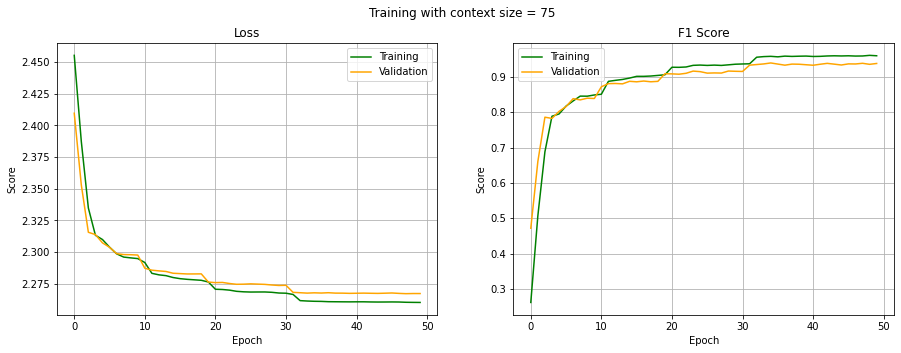

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9596, device='cuda:0'),
 tensor(0.9364, device='cuda:0'),
 tensor(0.9368, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9596, device='cuda:0'),
 tensor(0.9364, device='cuda:0'),
 tensor(0.9368, device='cuda:0'))

## Heatmap

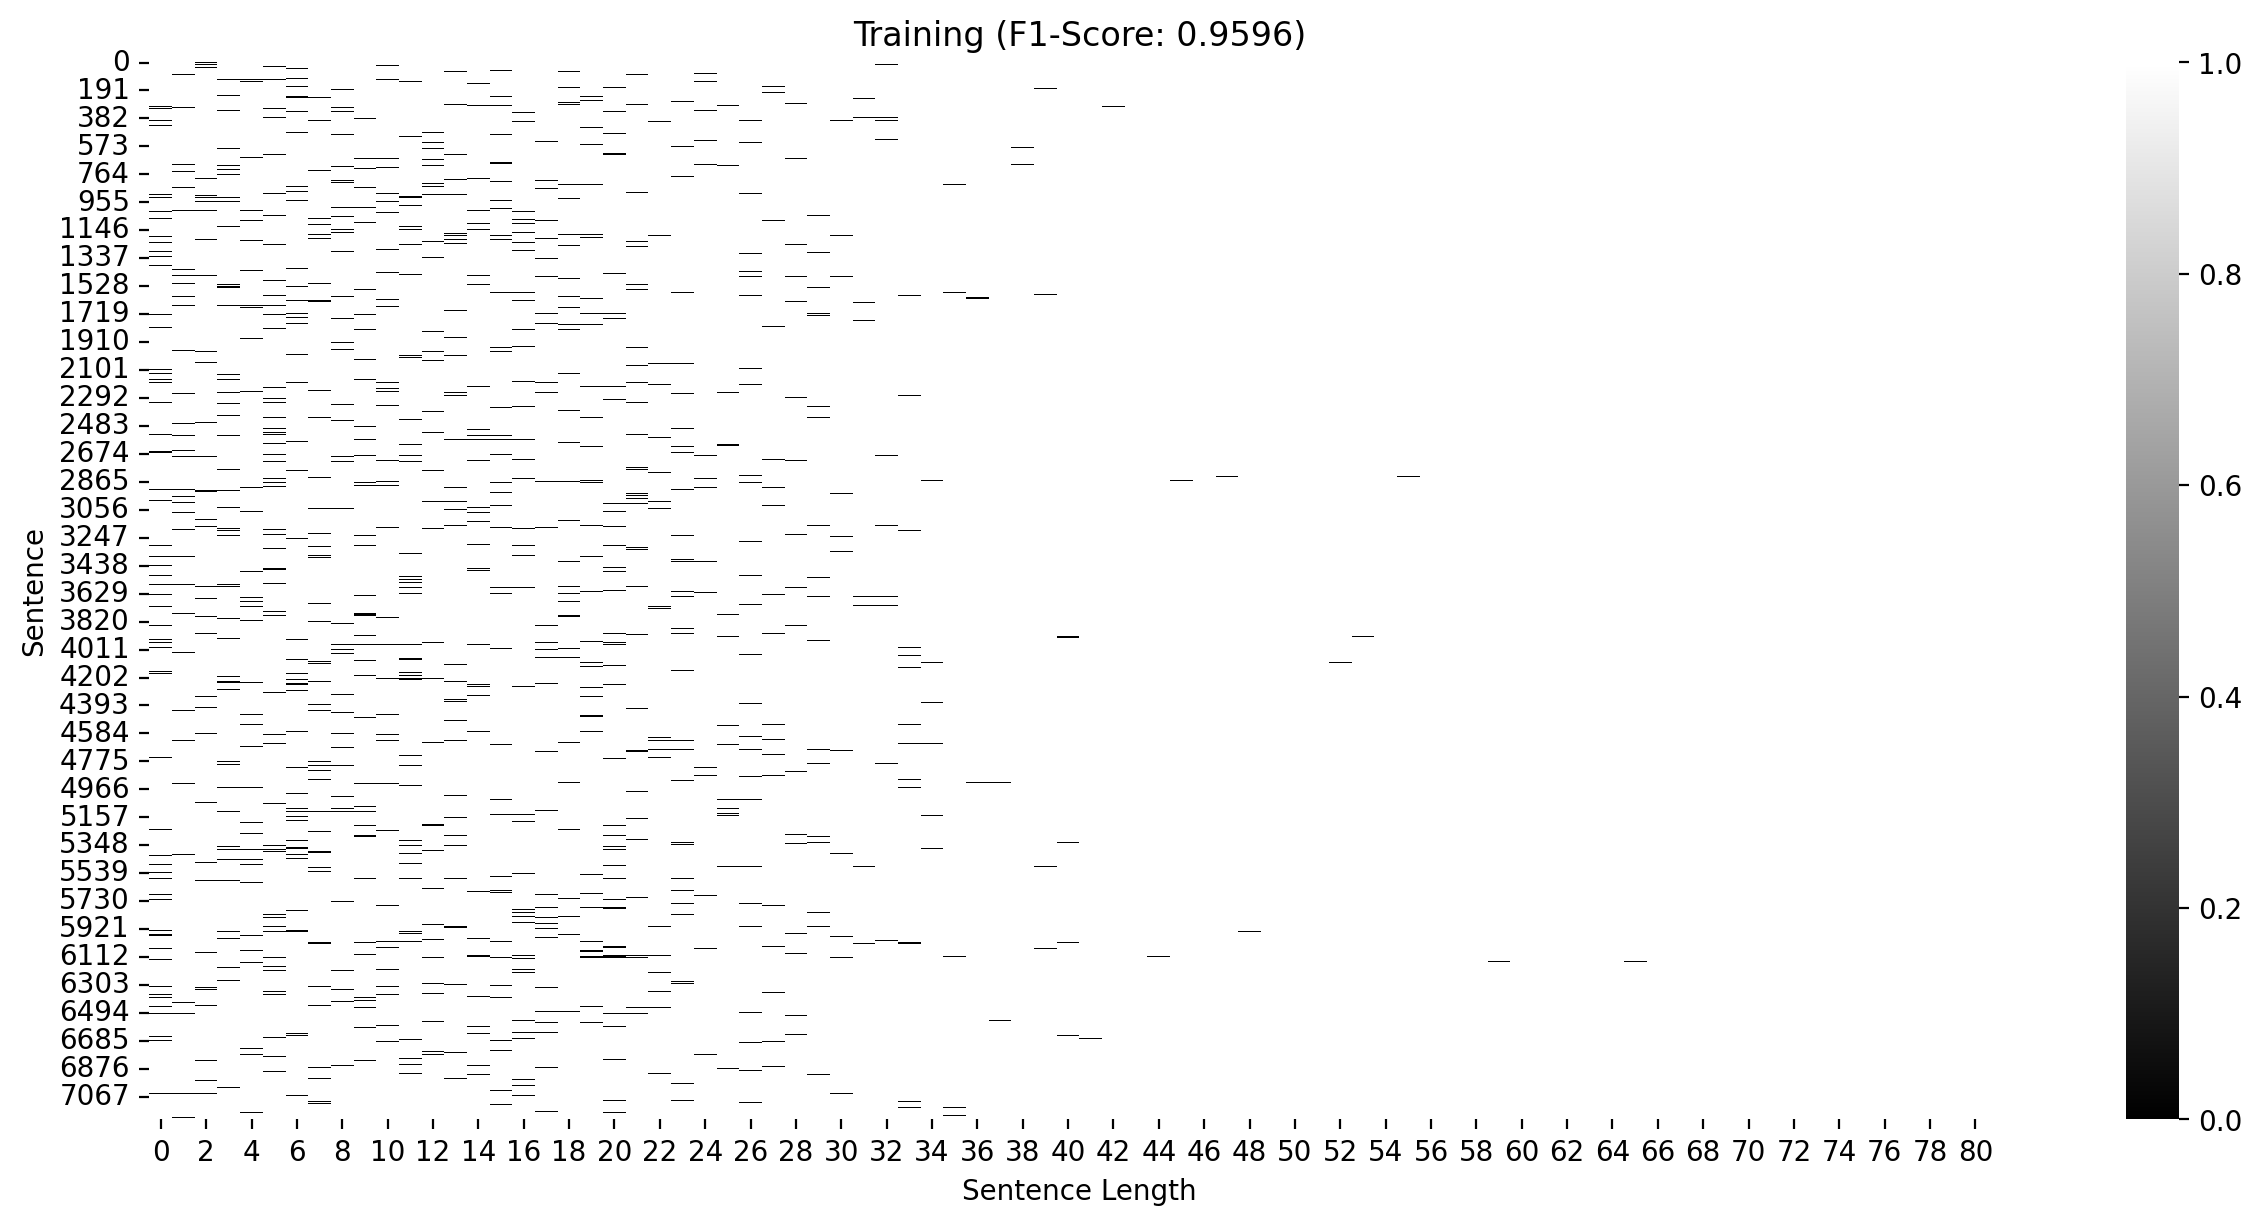

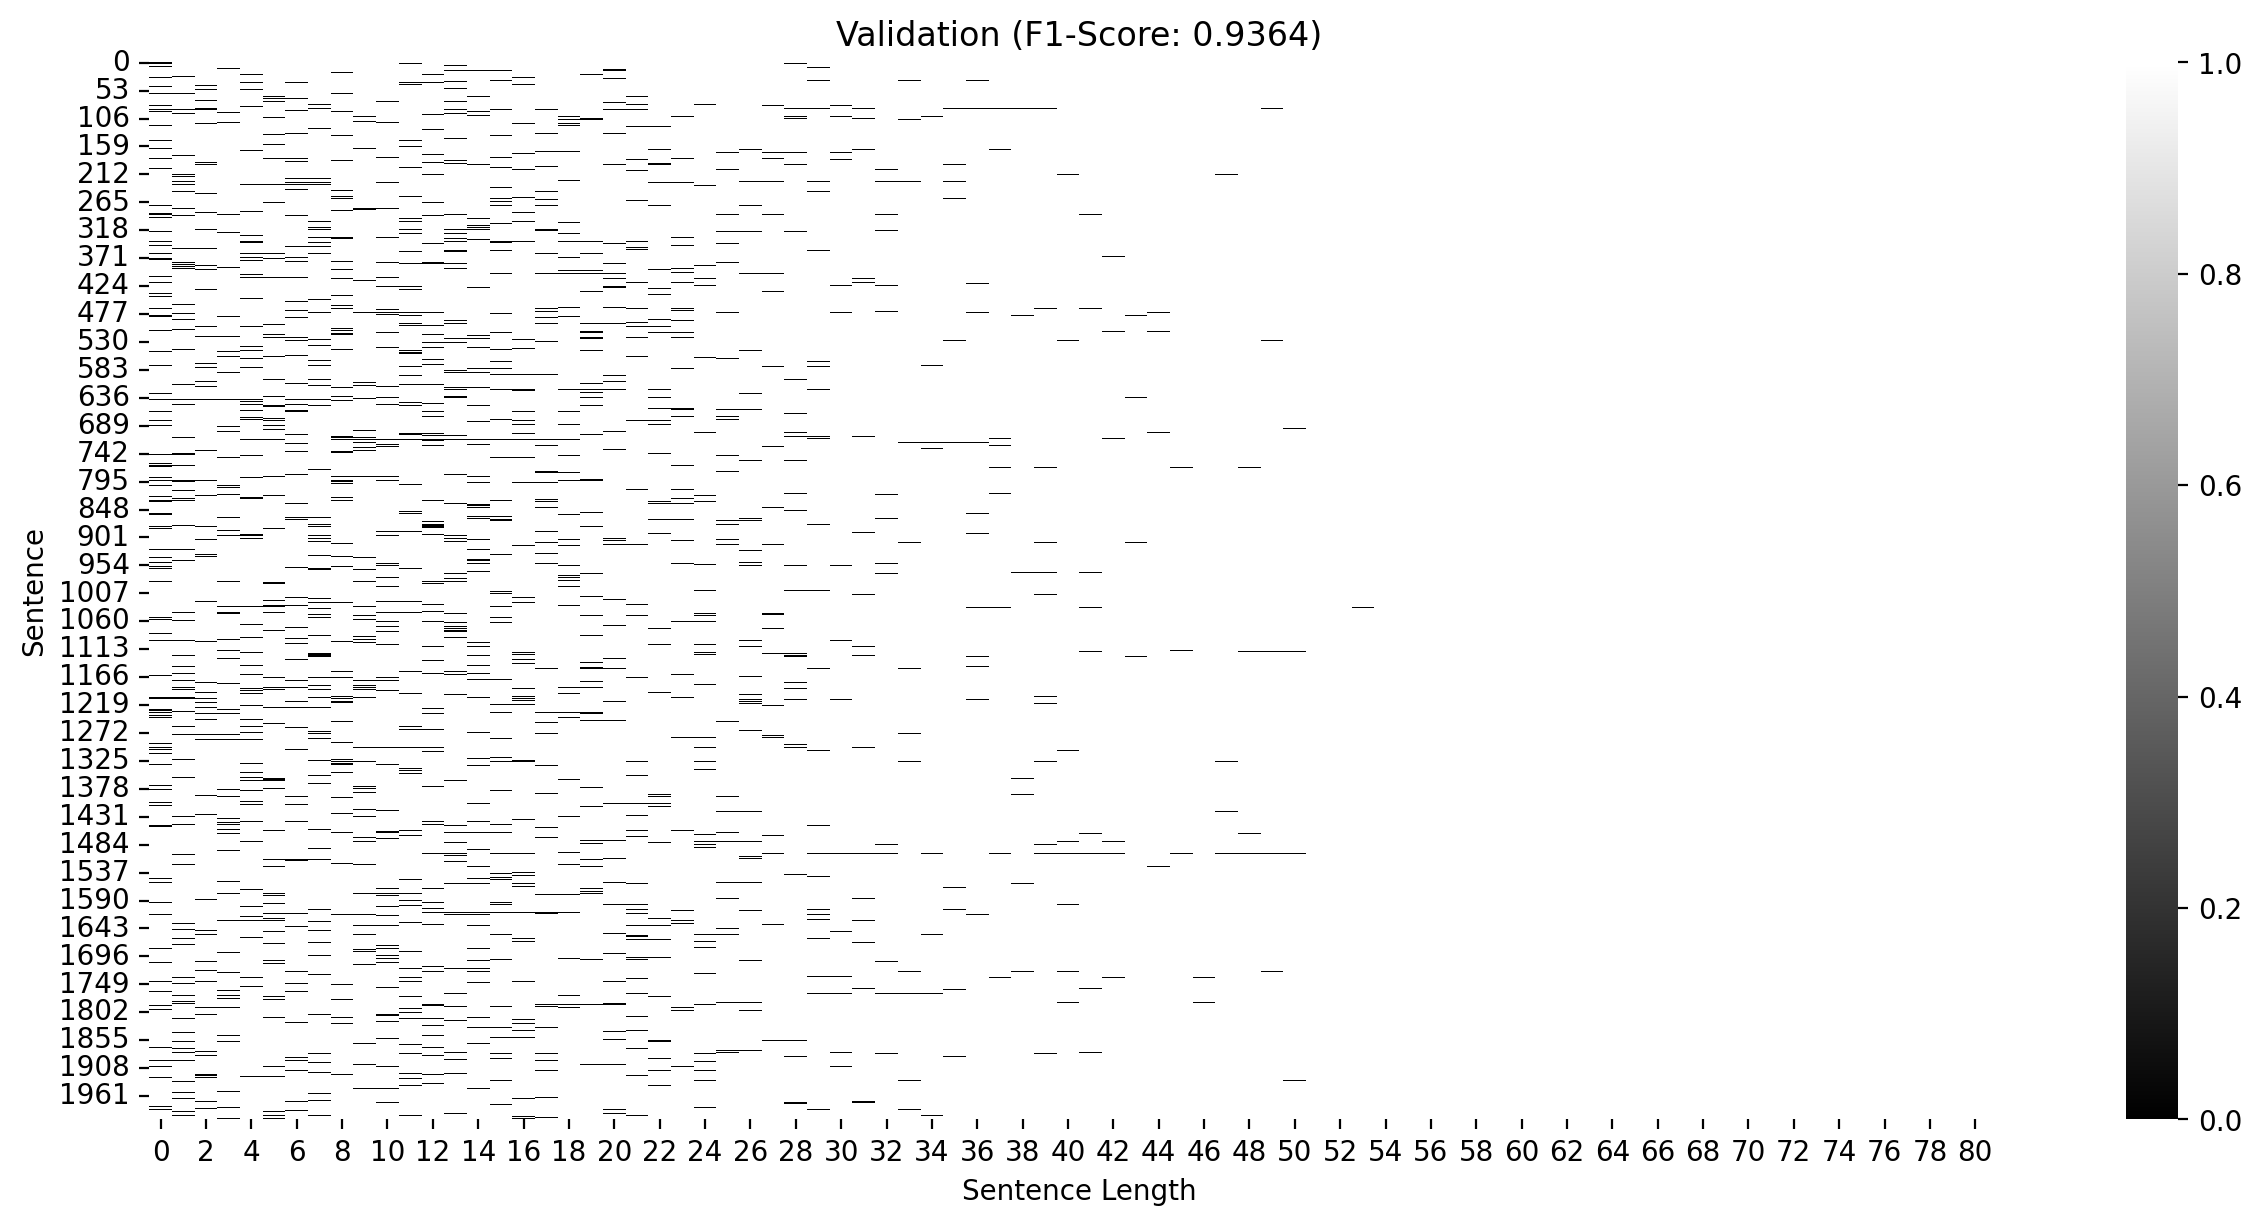

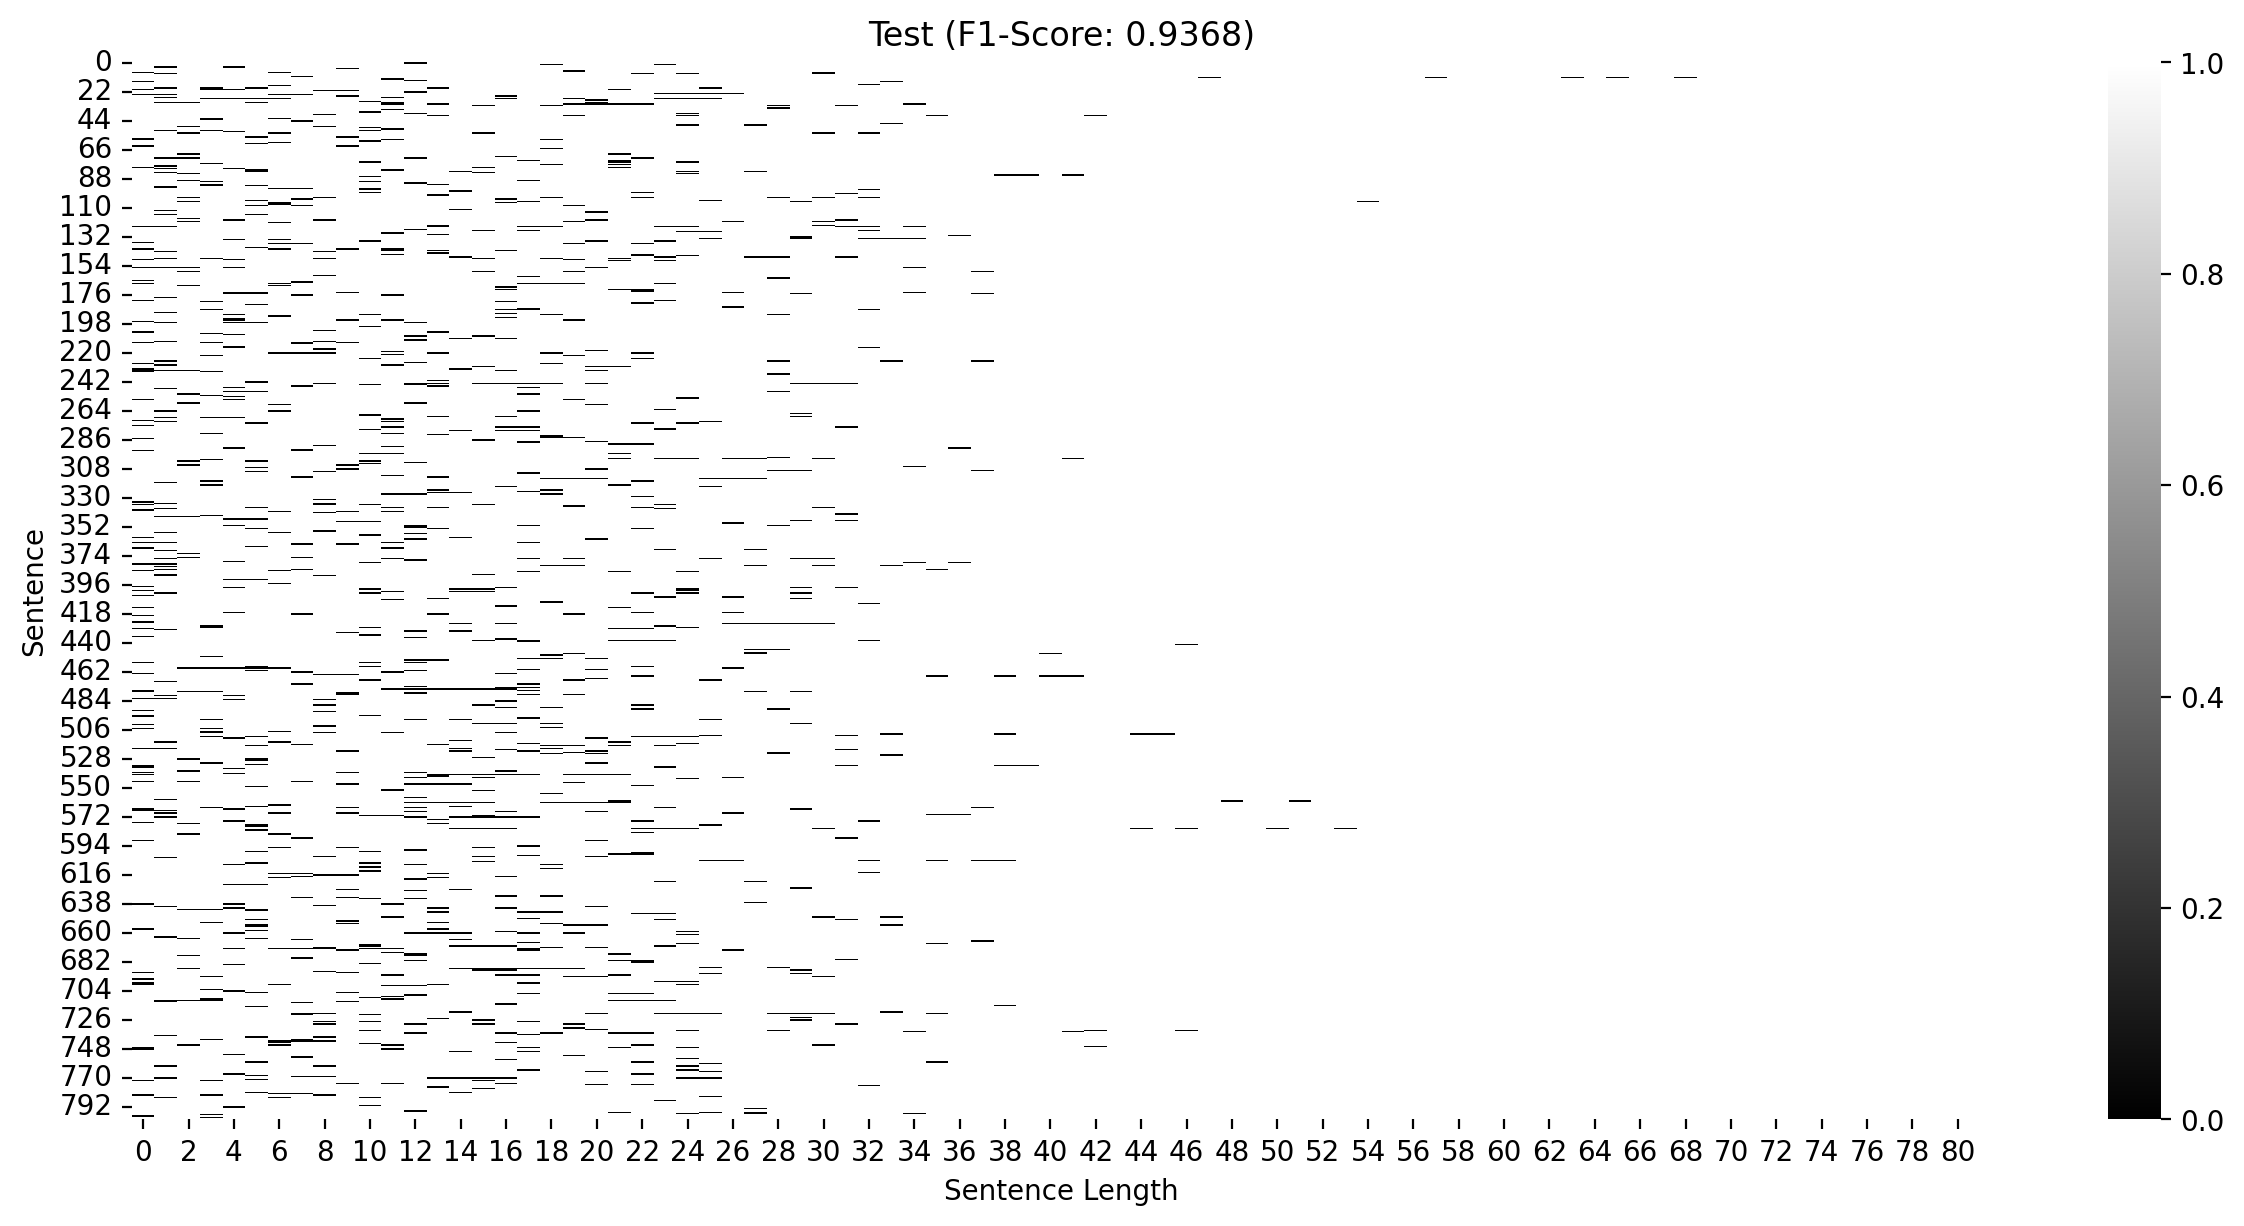

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 168 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


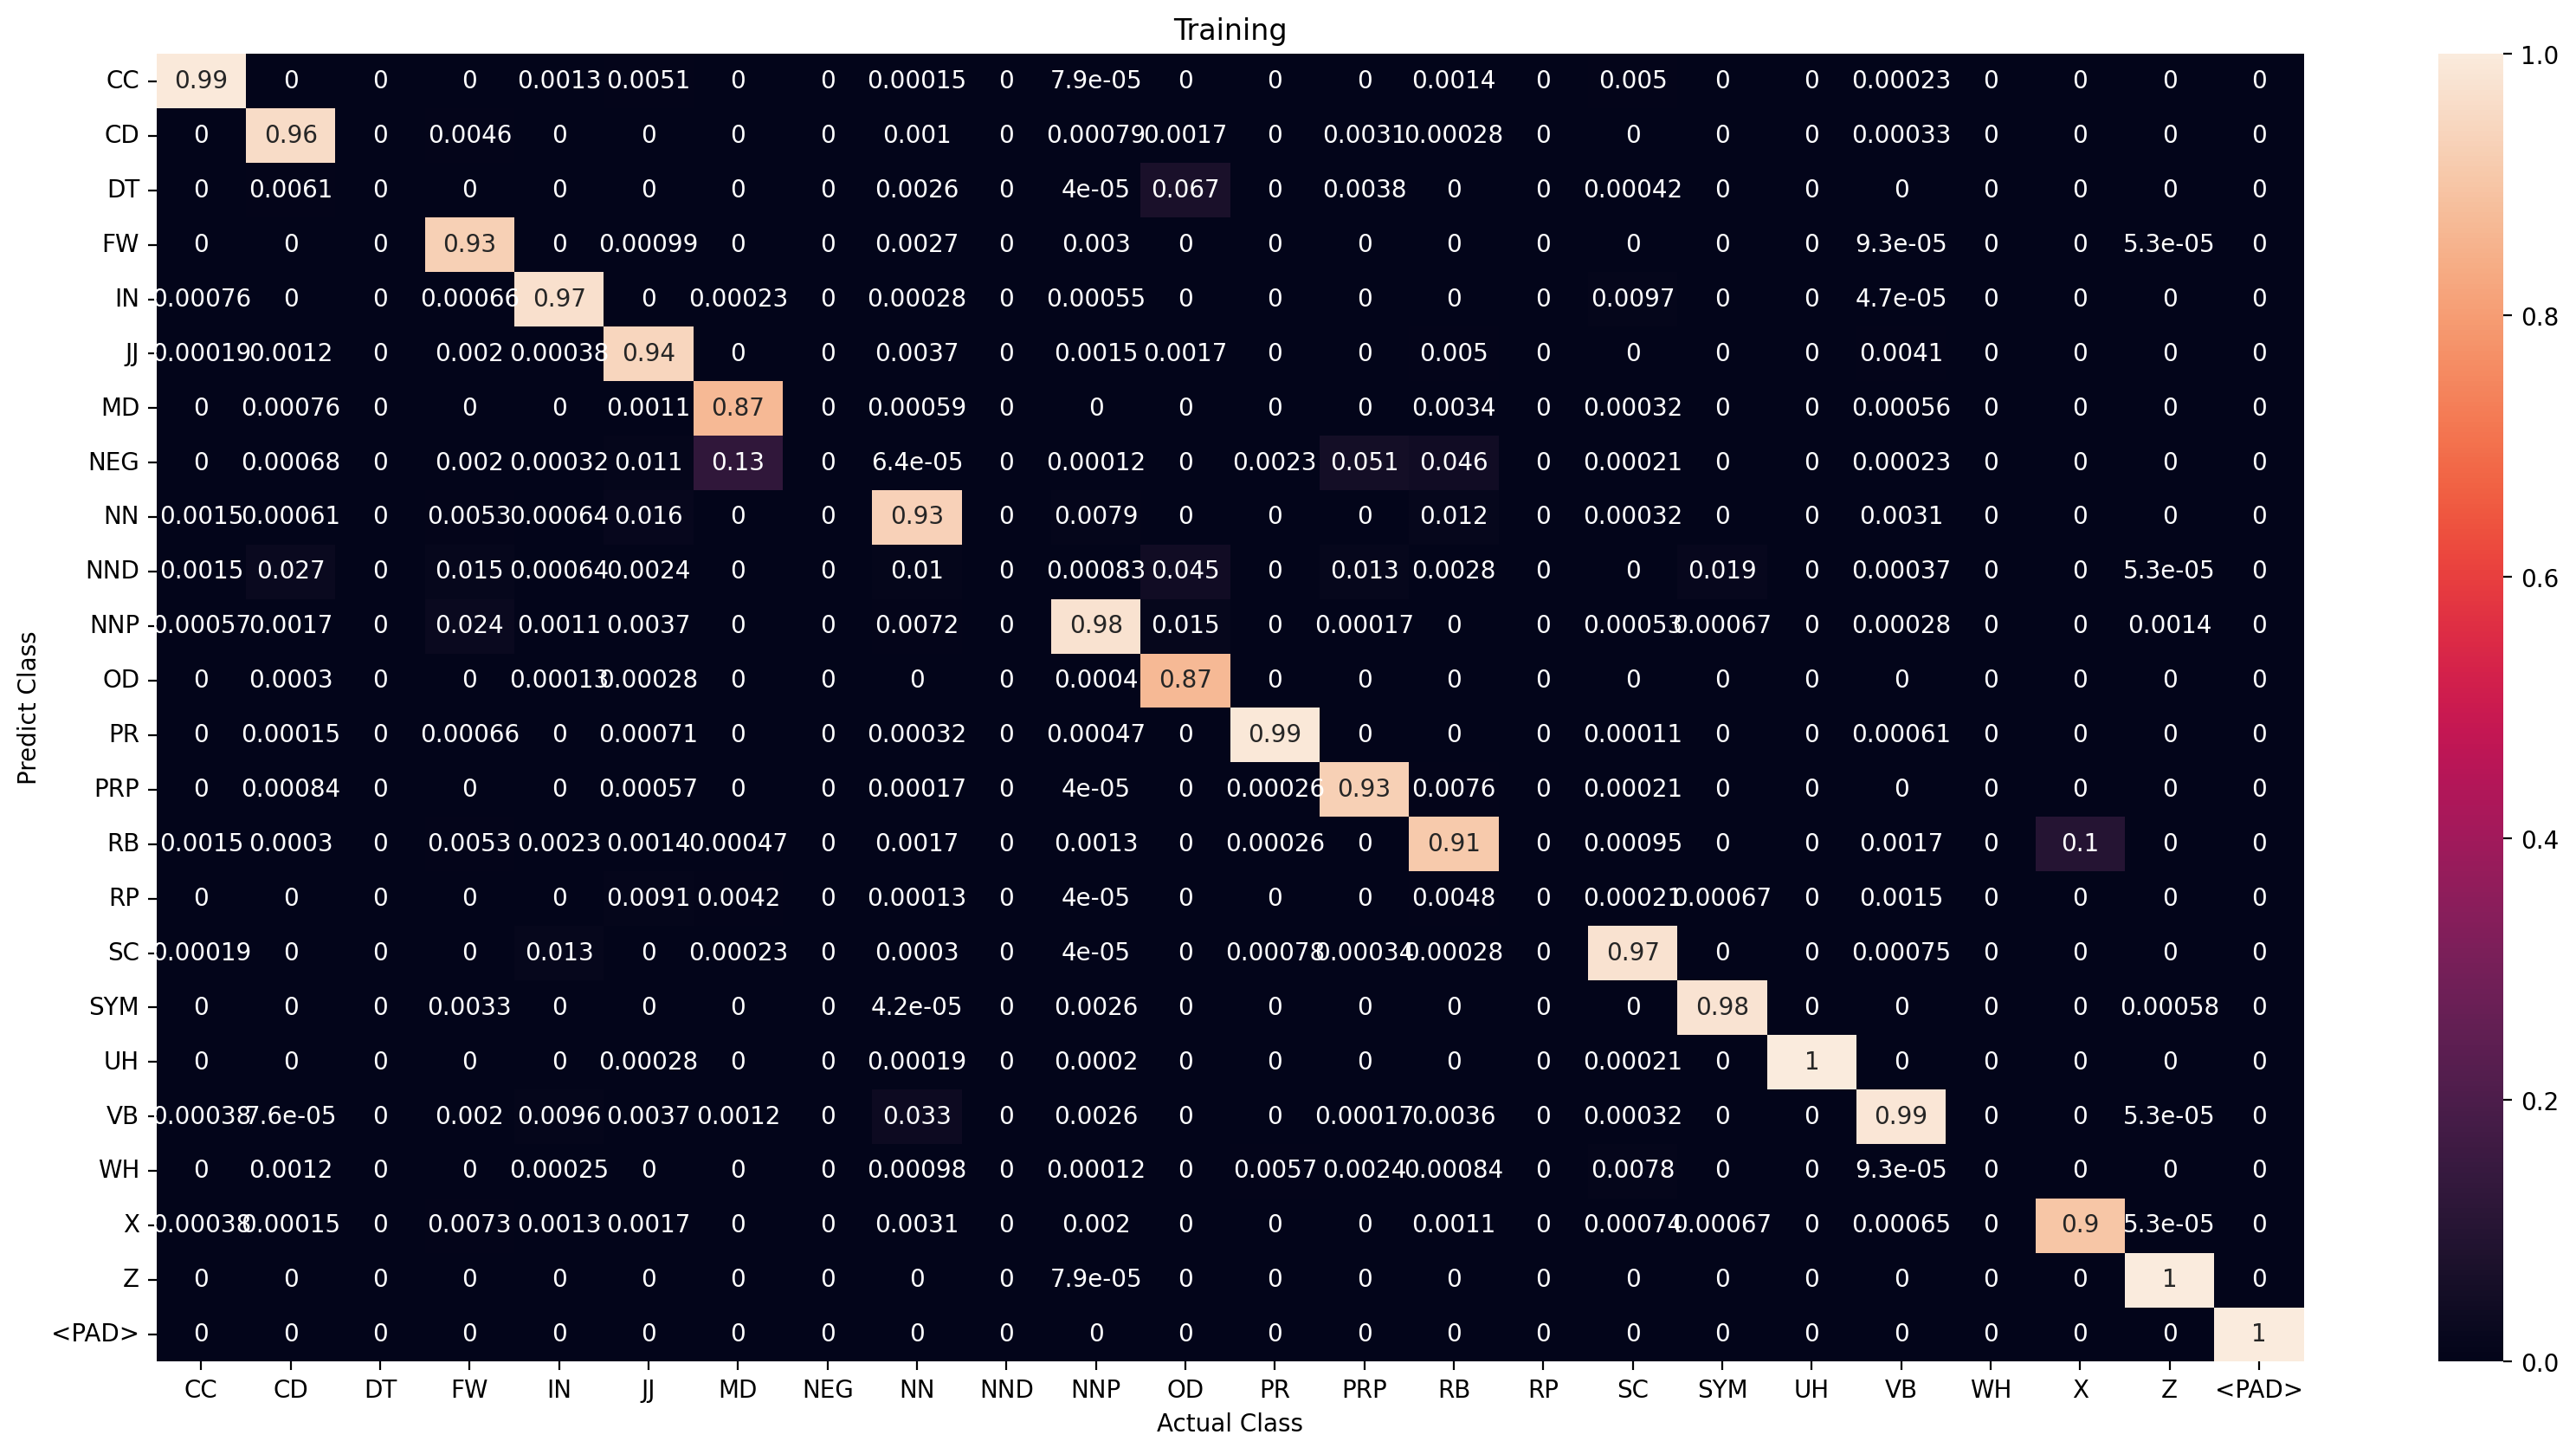

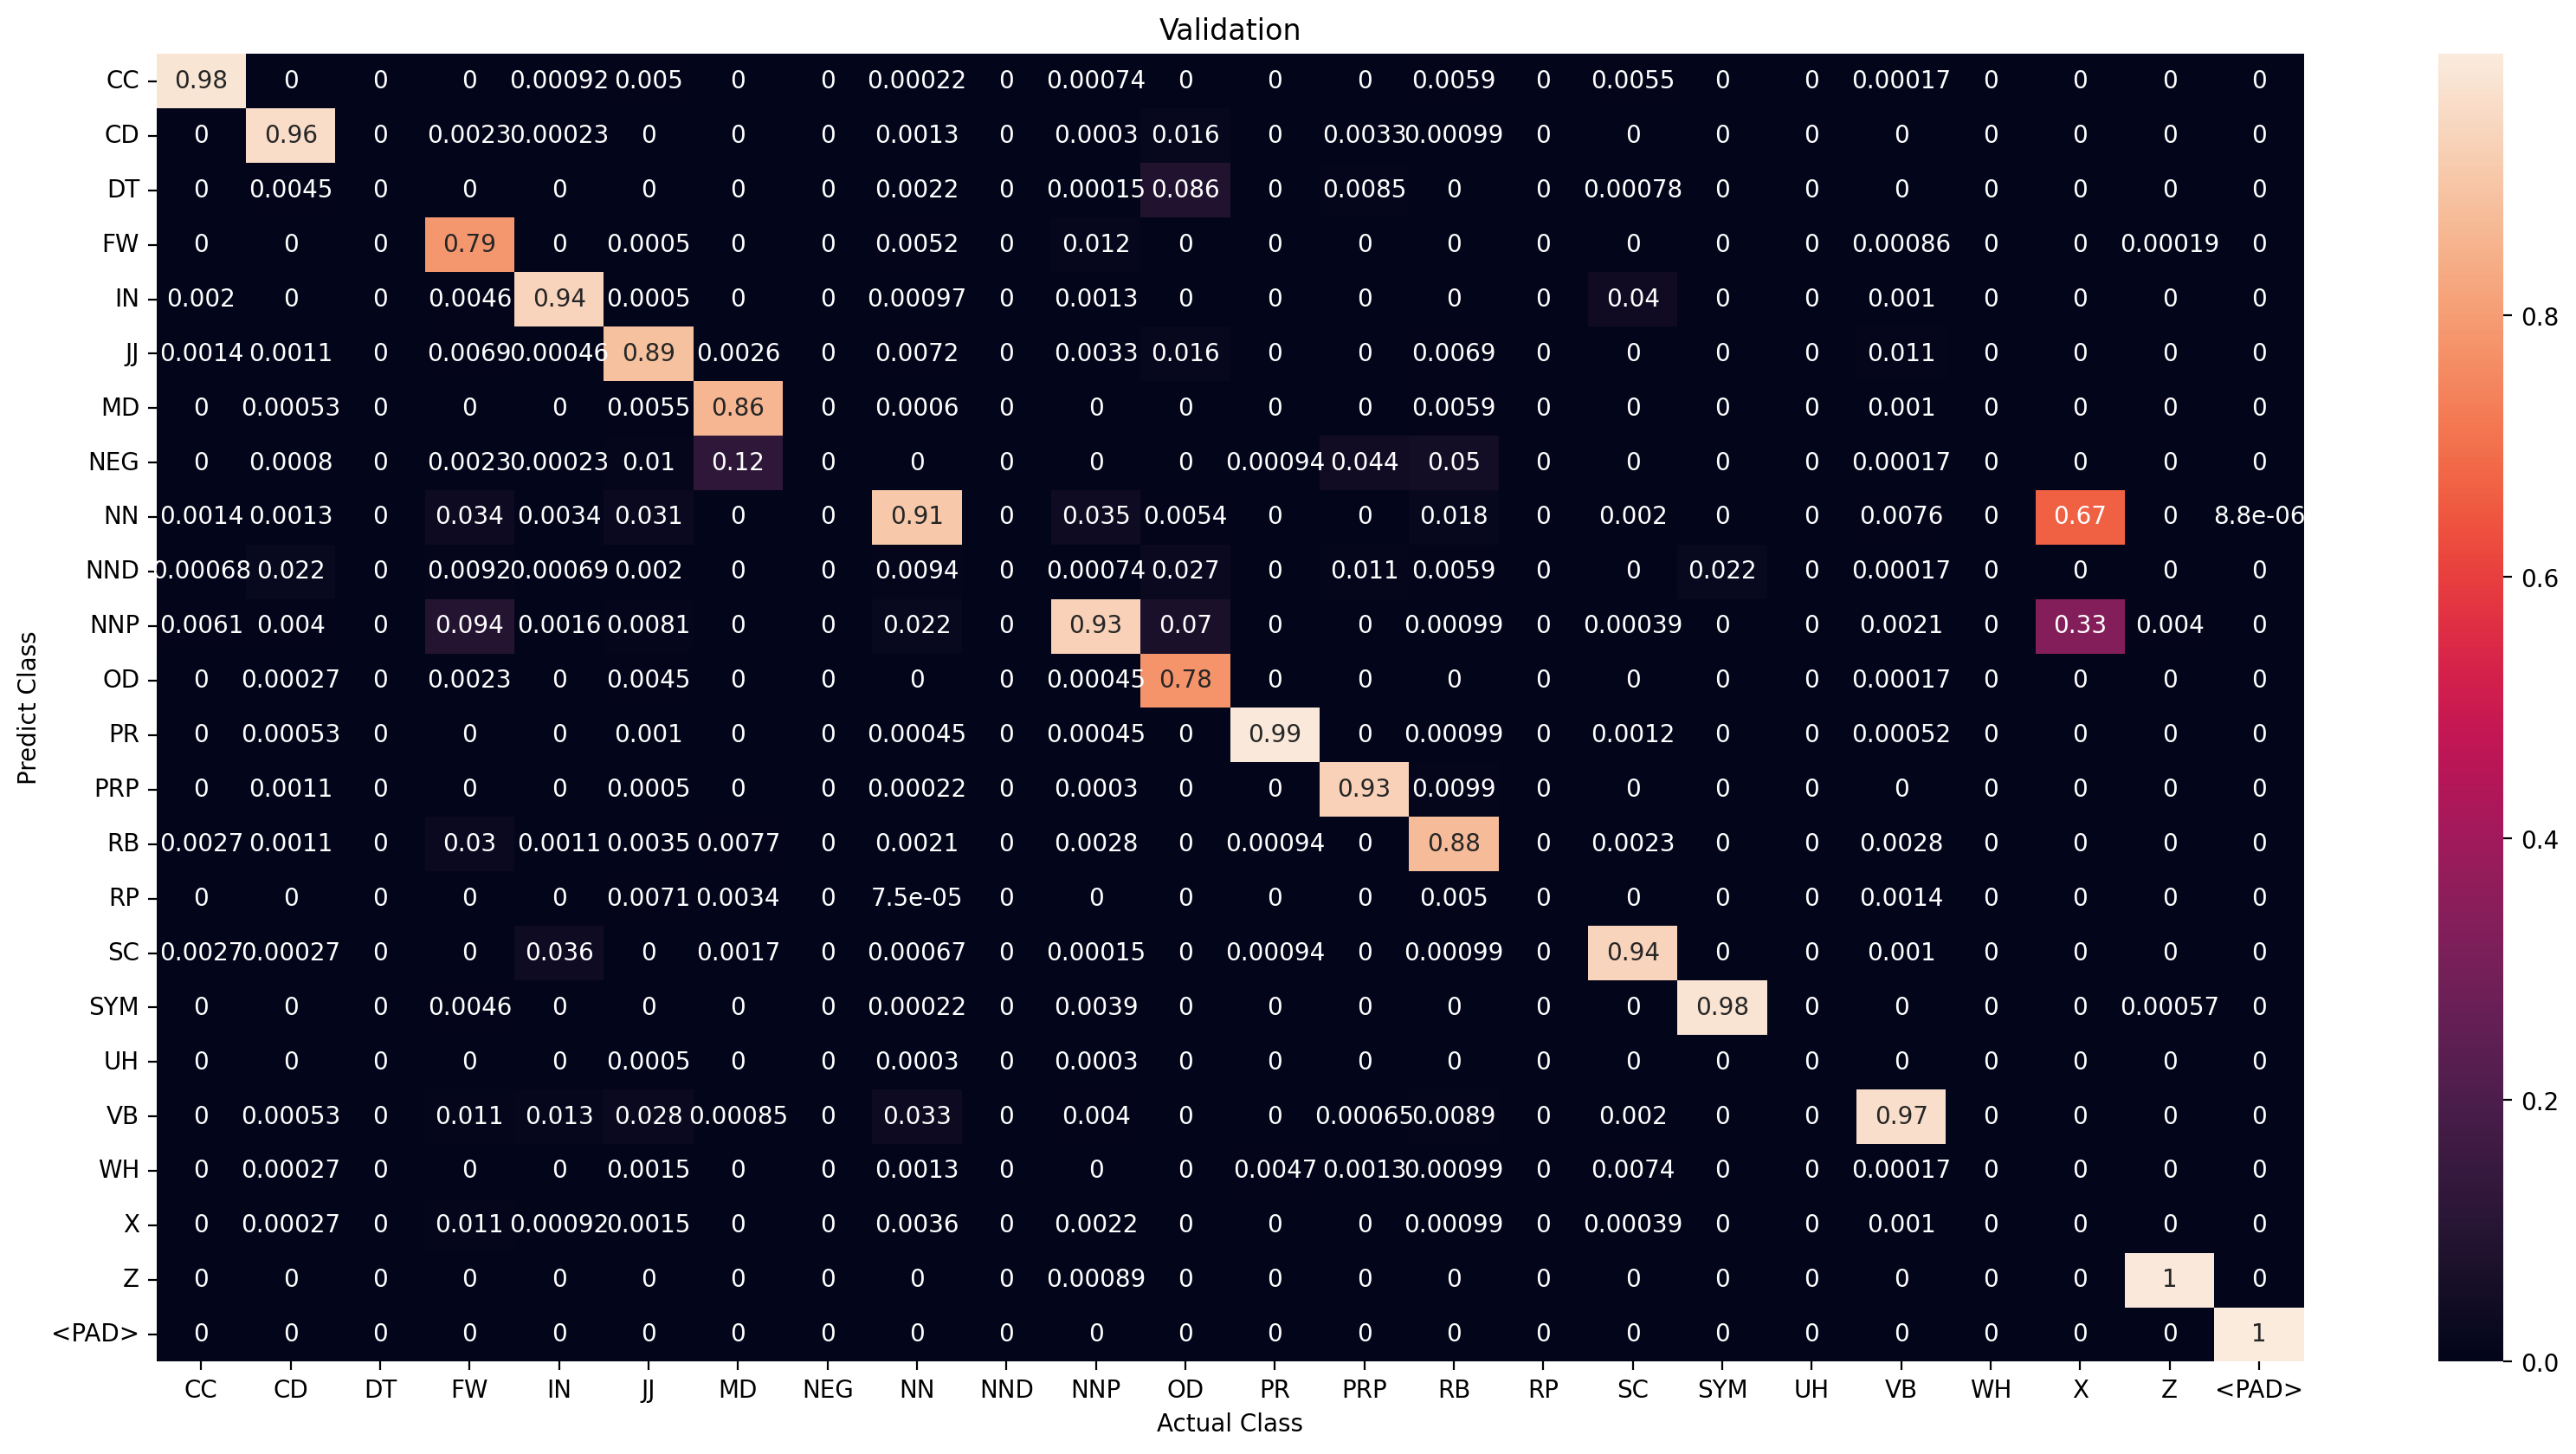

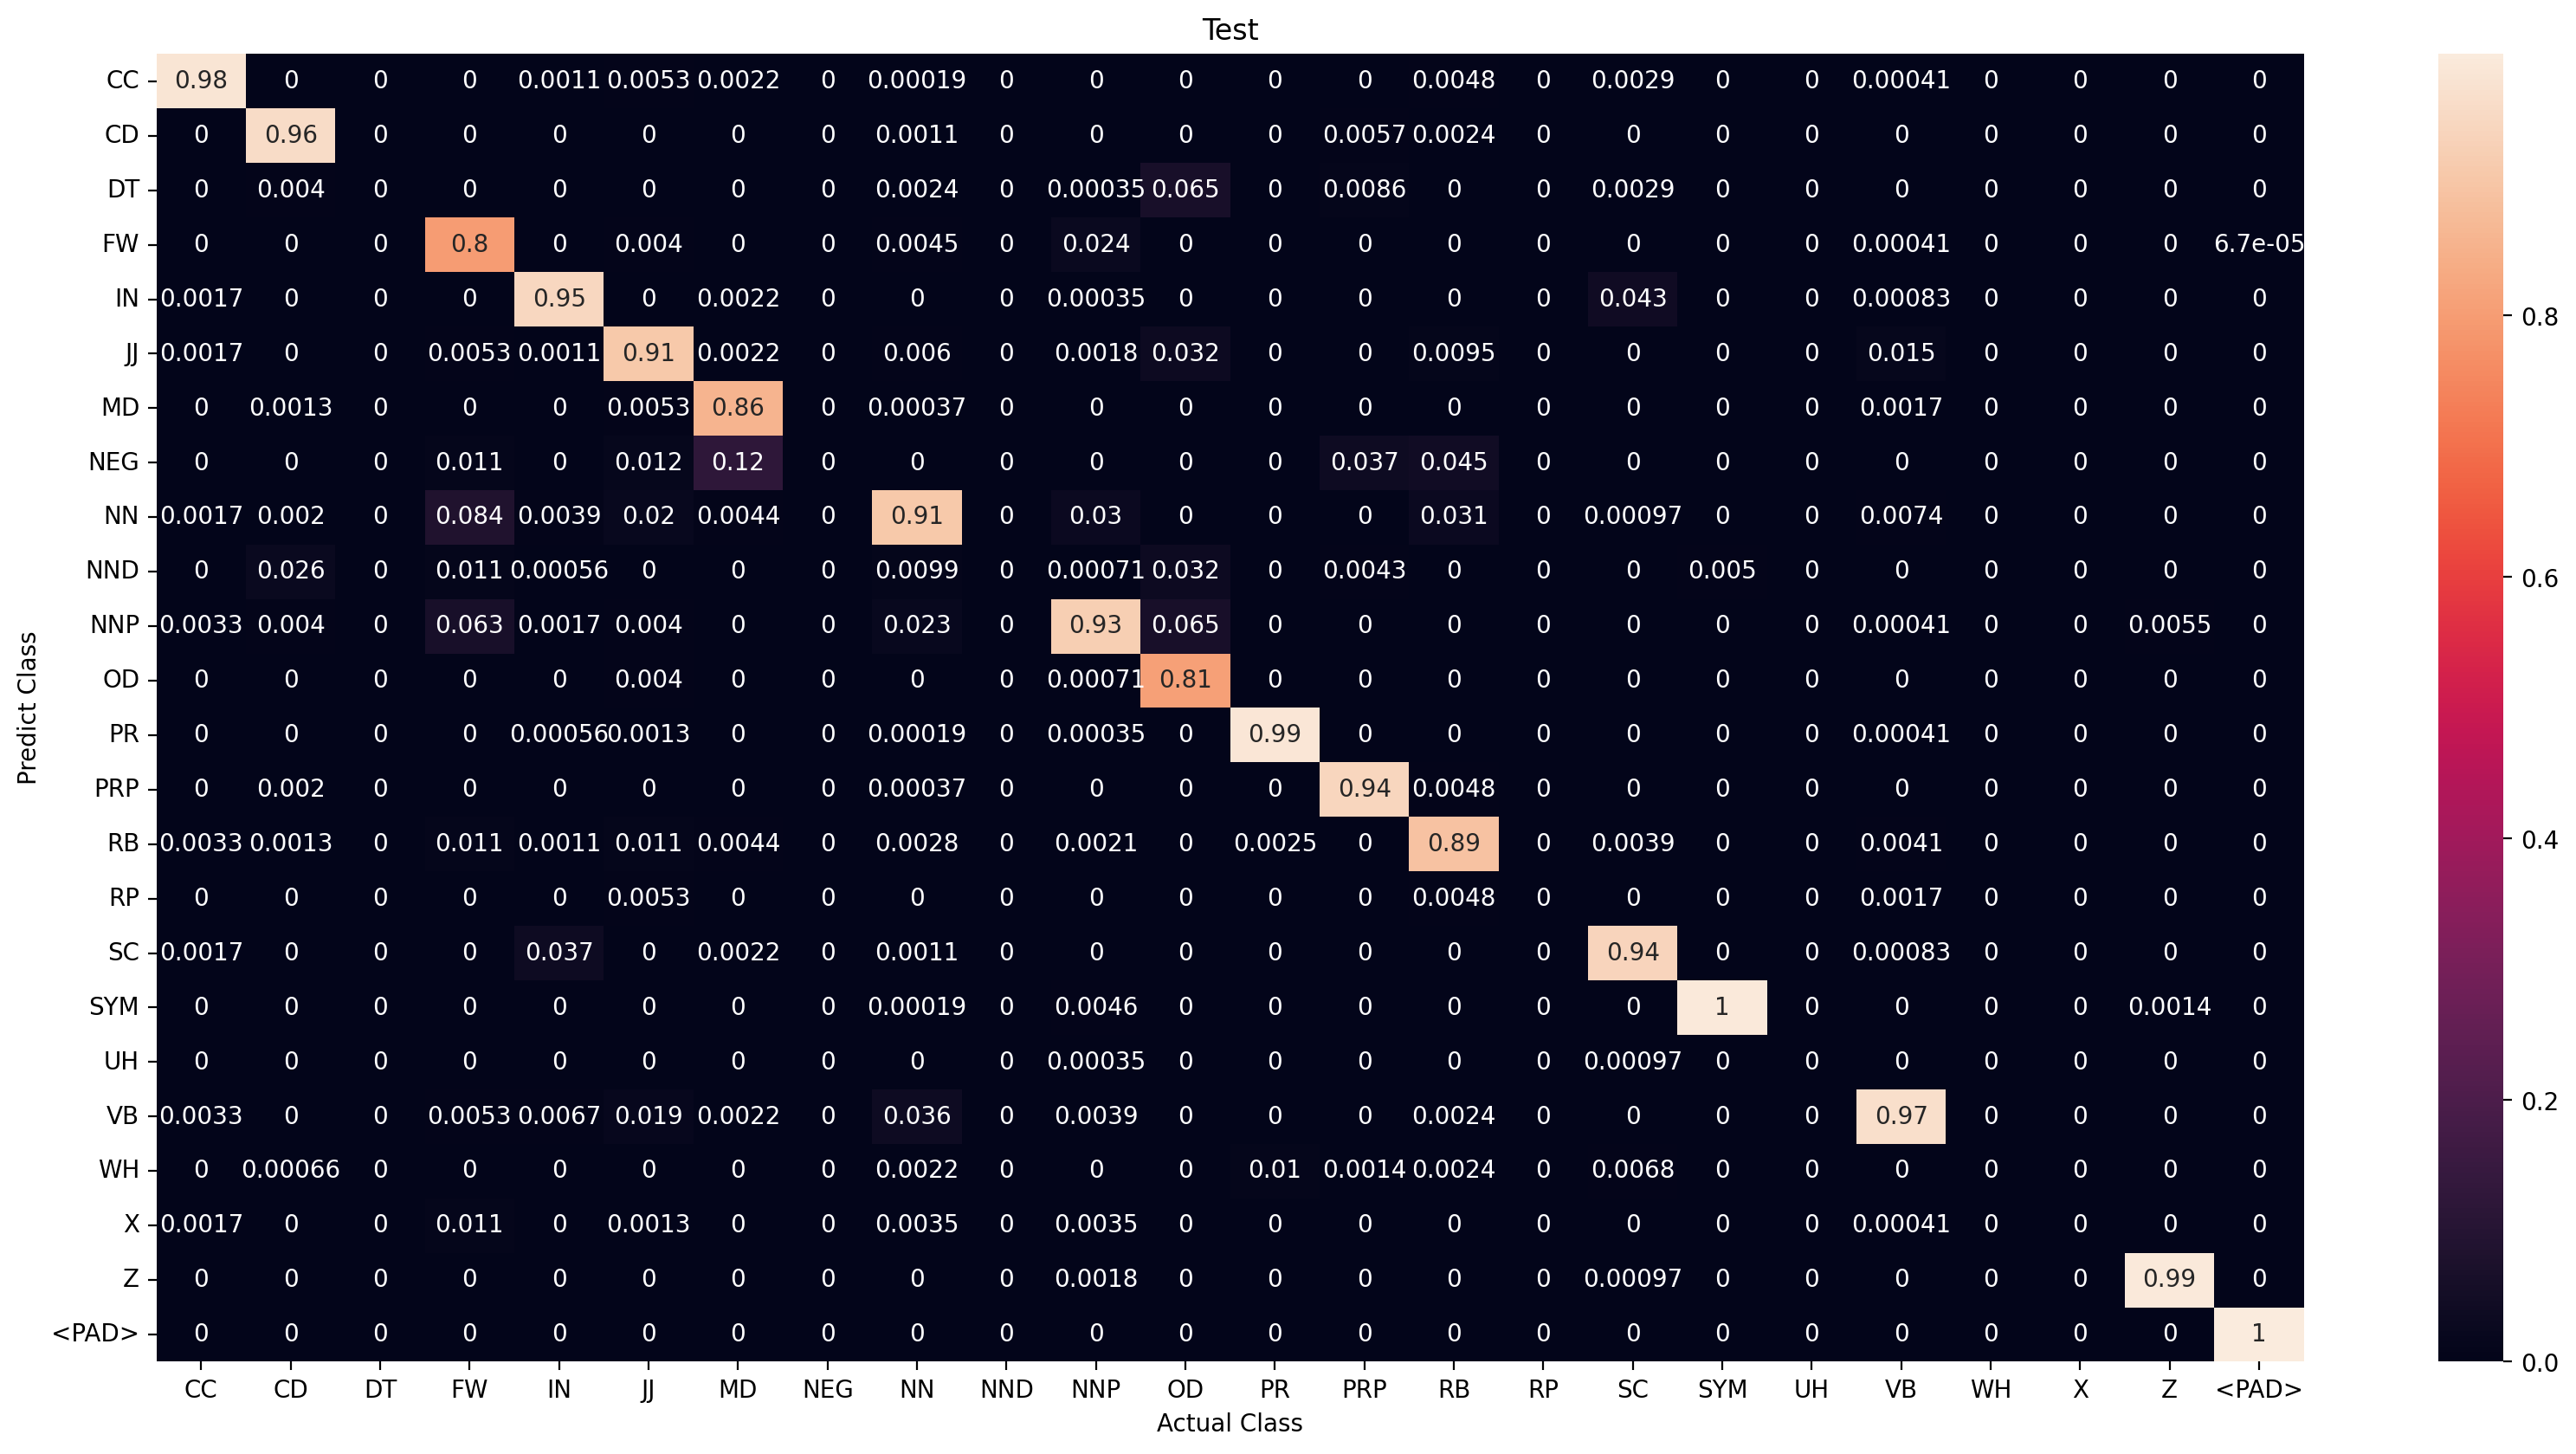

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5346   | CC    : 5223       | CC    : 123      |
| CD    : 12730  | CD    : 12629      | CD    : 101      |
| DT    : 269    | DT    : 0          | DT    : 269      |
| FW    : 1614   | FW    : 1402       | FW    : 212      |
| IN    : 15342  | IN    : 15216      | IN    : 126      |
| JJ    : 6981   | JJ    : 6639       | JJ    : 342      |
| MD    : 3799   | MD    : 3726       | MD    : 73       |
| NEG   : 1118   | NEG   : 0          | NEG   : 1118     |
| NN    : 44369  | NN    : 43908      | NN    : 461      |
| NND   : 1047   | NND   : 0          | NND   : 1047     |
| NNP   : 25175  | NNP   : 24683      | NNP   : 492      |
| OD    : 524    | OD    : 506        | OD    : 18       |
| PR    : 3880   | PR    : 3831       | PR    : 49       |
| PRP   : 5471   | PRP   : 5417       | PRP   : 54       |
| RB    : 3477   | RB    : 3250       | RB    : 227      |
| RP    : 141    | RP    : 0          | RP    : 141     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8,  3, 12, 19,  8,  8,  8, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8,  8, 12, 19,  8,  8,  5, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([ True, False,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11806
Correct prediction          : 11086
Wrong prediction            : 720
Percentage correct oov pred : 93.90140606471286

Validation
Number OOV token            : 3366
Correct prediction          : 2978
Wrong prediction            : 388
Percentage correct oov pred : 88.47296494355318

Test
Number OOV token            : 1390
Correct prediction          : 1244
Wrong prediction            : 146
Percentage correct oov pred : 89.49640287769785



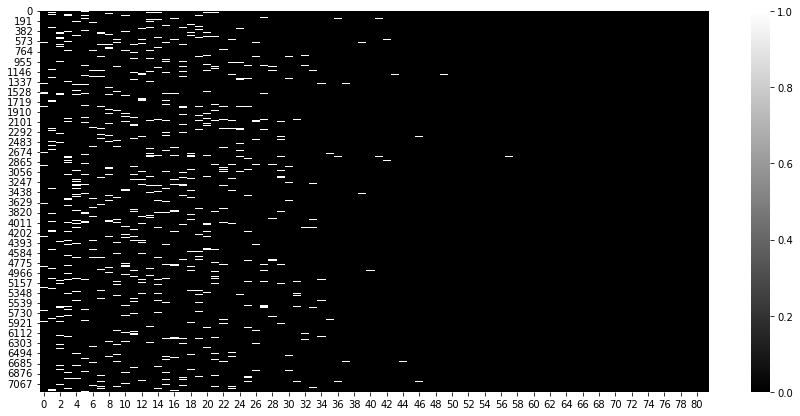

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

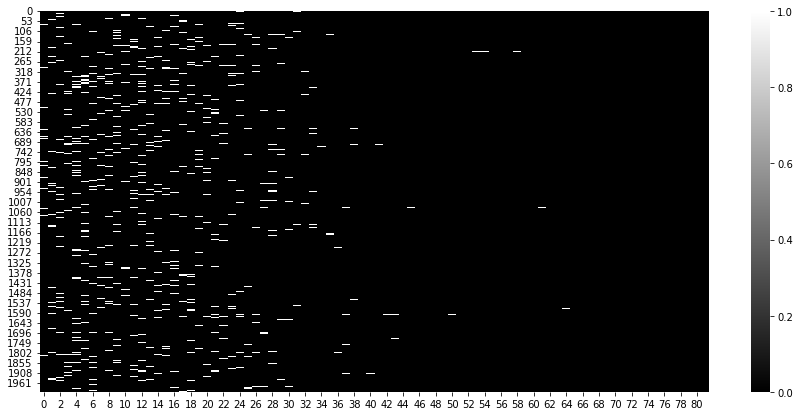

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

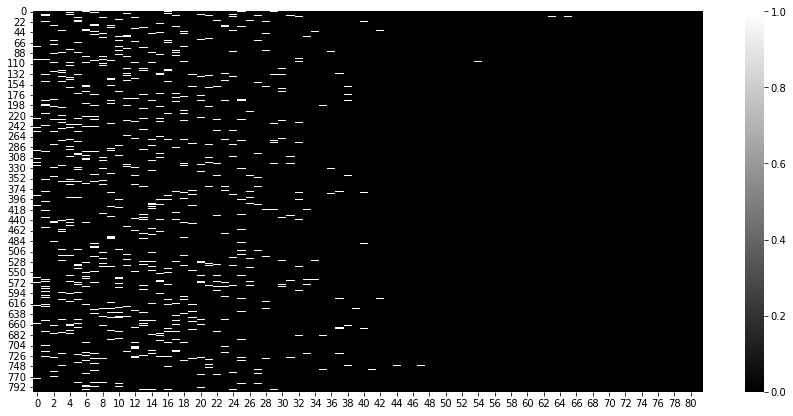

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);